In [1]:
# To ignore all warnings
import warnings
warnings.filterwarnings("ignore")


In [155]:
download_libraries("check")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to u

In [3]:
def download_libraries(command):
    if command=="check":
        %pip install numpy
        %pip install pandas
        %pip install seaborn
        %pip install matplotlib.pyplot
        %pip install matplotlib
        %pip install pandas_datareader
        %pip install scikit-learn
        %pip install getFamaFrenchFactors
        %pip install matplotlib 
        %pip install pandas-datareader 
        %pip install scikit-learn 
        %pip install plotly 
        %pip install ipython 
        %pip install random 
        %pip install yfinance 
        %pip install statsmodels 
        %pip install pulp
        %pip install pyarrow
        %pip install setuptools
        %pip install --upgrade certifi
        %pip install openpyxl



In [2]:
import matplotlib.pyplot as plt
import numpy as np, numpy.random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from sklearn.linear_model import LinearRegression
import plotly.express as px
from IPython.display import Markdown as md
import random as rand
from matplotlib import gridspec
import yfinance as yf
from datetime import datetime
# import getFamaFrenchFactors as gff
from pandas.tseries.offsets import DateOffset
from statsmodels.formula.api import ols
import statsmodels.api as sm
import random
# yf.pdr_override()
import pulp
from sklearn.preprocessing import LabelEncoder
import pandas_datareader.data as reader
import yfinance as yf
import pandas as pd
import requests
# import getFamaFrenchFactors as gff
from pulp import LpProblem, LpMaximize, LpVariable, LpMinimize, LpBinary, lpSum
from pulp import *

In [4]:
import getFamaFrenchFactors as gff

In [5]:
yf.pdr_override()


In [35]:
def get_spy(beta1,beta2,beta3,start,end):
  
    global tickers
    requests.packages.urllib3.disable_warnings() 
    # Fetch HTML content
    response = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', verify=False)
    html_content = response.content
    # Read HTML content into pandas DataFrame
    list_of_dfs = pd.read_html(html_content)
    wikitable_sp_500 = list_of_dfs[0]
    sp500_symbols = wikitable_sp_500['Symbol']#Converting SP_500 tickers into list 
    tickers = sp500_symbols.to_list()#Remove some tickers as they create an error for the yfinance api
    tickers[65] = 'BRK-B'
    tickers[81] = 'BF-B'
    tickers.remove('BF-B')
    tickers.remove('BRK-B')#Start Date for In Sample Historical Data
    global monthly_data
    global base_w
    monthly_data = yf.download(tickers,start=start,end=end,interval='1mo')#Reformat Date Index 
    monthly_data.index = pd.to_datetime(monthly_data.index)
    monthly_data = monthly_data.tz_localize(None)#Turn Adj Close prices into pct returns
    monthly_data = monthly_data['Adj Close'].pct_change()#Drop First row NaN values
    monthly_data = monthly_data.drop(monthly_data.index[0])#Drop if stock doesnt have data starting from the first index date
    monthly_data = monthly_data.dropna(axis=1)#Assign equal weight as base weights
    
    base_w = {k: 1/len(monthly_data.columns) for k in monthly_data.columns}
    base_w = pd.DataFrame.from_dict(base_w, orient='index', columns=['Weight'])#Getting SP_500 data
    spy = pd.DataFrame(yf.download('^GSPC',start=start,end=end,interval='1mo')['Adj Close'].pct_change())#Dropping First Row(NaN) and formatting index to match monthly_data 
    spy = spy.drop(spy.index[0]).tz_localize(None)#Adding SP_500 data to monthly_data
    monthly_data['SP_500'] = spy['Adj Close']
    #Adjusting tickers list as some tickers will not be included in the monthly_data if there is no data for test date range
    
    tickers = list(monthly_data.columns[:-1])
    tick_index = tickers + ['SP_500']

    

In [1]:
start

NameError: name 'start' is not defined

In [7]:
def famafrenchreturns():
    global ff3_monthly
    # Fama French Monthly Returns Data using getFamaFrenchFactors module
    ff3_monthly = gff.famaFrench3Factor(frequency='m')
    ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
    ff3_monthly.set_index('Date', inplace=True)
    ff3_monthly.index = ff3_monthly.index.to_period('M').to_timestamp('D')
    # Keeping Only the Dates in the monthly_data
    ff3_monthly = ff3_monthly.loc[monthly_data.index]
    

In [8]:
def to__cal_stock_betas():
    global stock_betas
    stock_betas = pd.DataFrame()
    # Iterate over the tickers list
    for col in monthly_data.columns:
        # Set the dependent variable (Return of stock i)
        y = monthly_data[col]
        # Set the independent variables (Fama French 3 Factors)
        X = ff3_monthly[['Mkt-RF','SMB','HML']]
        # Fit the multiple linear regression model
        model = LinearRegression()
        model.fit(X, y)
        # Store the results in the DataFrame
        stock_betas[col] = [model.intercept_] + list(model.coef_)
    stock_betas = stock_betas.T
    stock_betas.columns = ['Intercept','Mkt-RF','SMB','HML']

In [9]:
def to_cal_stock_price():
    global stock_price
    global s_price
    global s_keys
    global s_values
    #Stock Prices on the Day of Optimization(Rebalancing)
    stock_price = pd.DataFrame(yf.download(tickers,start=start,end=end,interval='1d')['Adj Close'])
    stock_price = stock_price[-1:]
    stock_price.index = pd.to_datetime(stock_price.index).tz_localize(None)
    s_price = {}
    s_keys = list(tickers)
    s_values =  list(stock_price.iloc[0])
    for key,value in zip(s_keys,s_values):
        s_price[key] = value

In [10]:
def Transaction_Costs(initialize=False):
    if initialize:
        random.seed(1)  # Set seed only during initialization
    global t_cost
    t_cost = {}
    global keys
    keys = list(tickers)
    values = list(random.uniform(.01, .02) for i in range(len(tickers)))
    for key, value in zip(keys, values):
        t_cost[key] = value


In [11]:
def optimization():
# OPTIMIZATION MODEL
    global index
    global wei
    global aux
    global err
    global binary
    global tr_cost
    global shares
    index = LpProblem('Index', LpMinimize) 
    # Decision Variables
    wei = LpVariable.dicts('Weight',tickers,lowBound=0)                           # Weights for stock i in the optimal portfolio
    aux = LpVariable.dicts('Y',tickers,lowBound=0)                                # Absolute value of change for stock i from base weights
    err = LpVariable.dicts('Error', monthly_data.index, lowBound=0)               # Error term for portfolio
    binary = LpVariable.dicts('bin',tickers,cat=LpBinary)                         # Used if we want to limit the # of stocks we want to have in optimal portfolio
    tr_cost = LpVariable.dicts('Transaction_Cost',tickers,lowBound=0)             # Total Transaction cost for stock i in the optimal portfolio
    shares = LpVariable.dicts('shares',tickers,lowBound=0)                        # Total Transaction cost for stock i in the optimal portfolio
    #Objective Function - Minimize the error term 
    index +=  lpSum(err[t] for t in monthly_data.index) # Constraint: Weights sum to 1 
    index += lpSum(wei[i] for i in tickers) == 1
    # Constraint: Absolute value of change in weights from base weigths
    for i in tickers:
        index += aux[i] >= base_weights[i]  - wei[i]
        index += aux[i] >= wei[i] - base_weights[i]
    index += lpSum(aux[i] for i in tickers) <= 1 
    # Constraint: Error term
    for t in monthly_data.index:
        index += lpSum(wei[i]*(monthly_data.loc[t,i]-ff3_monthly.loc[t,'RF']) for i in tickers) - err[t] <= (mkt_opt*ff3_monthly.loc[t,'Mkt-RF']+smb_opt*ff3_monthly.loc[t,'SMB']+hml_opt*ff3_monthly.loc[t,'HML'])
        index += lpSum(wei[i]*(monthly_data.loc[t,i]-ff3_monthly.loc[t,'RF']) for i in tickers) + err[t] >= (mkt_opt*ff3_monthly.loc[t,'Mkt-RF']+smb_opt*ff3_monthly.loc[t,'SMB']+hml_opt*ff3_monthly.loc[t,'HML'])
    # Shares
    for i in tickers:
        index += shares[i] == (aux[i]*B/s_price[i])
    # Transaction Costs
    for i in tickers:
        index += lpSum(aux[i] *B*t_cost[i]/s_price[i]) == tr_cost[i]
    index += lpSum(tr_cost[i] for i in tickers) <= 2000
    # Limit # of stocks in Optimal Portfolio
    for i in tickers: # Forces weight of stock i to be less than binary value of stock i. If stock is not selected binary variable is 0 which then forces weight of stock i to be in the optimal portfolio to be 0.
        index += wei[i] <= binary[i]
    index += lpSum(binary[i] for i in tickers) <= q
    index.solve()
    

In [12]:
def others():
    global sharess
    #Change in number of shares
    sharess = pd.DataFrame([v.varValue for v in index.variables() if str(v.name)[0] == 's'], index = [str(v.name) for v in index.variables() if str(v.name)[0] == 's'] , columns = ['Optimal'])
    sharess
    global tr_cost
    #Transaction Costs
    tr_cost = pd.DataFrame([v.varValue for v in index.variables() if str(v.name)[0] == 'T'], index = [str(v.name) for v in index.variables() if str(v.name)[0] == 'T'] , columns = ['Optimal'])
    tr_cost.sum()
    global weii
    #Optimal weights
    weii = pd.DataFrame([v.varValue for v in index.variables() if str(v.name)[0] == 'W'], index = [str(v.name) for v in index.variables() if str(v.name)[0] == 'W'] , columns = ['Optimal'])
    weii.sum()
    global auxx
    #Change of weights
    auxx = pd.DataFrame([v.varValue for v in index.variables() if str(v.name)[0] == 'Y'], index = [str(v.name) for v in index.variables() if str(v.name)[0] == 'Y'] , columns = ['Optimal'])
    auxx.sum()
    global errr
    #Error terms
    errr = pd.DataFrame([v.varValue for v in index.variables() if str(v.name)[0] == 'E'], index = [str(v.name) for v in index.variables() if str(v.name)[0] == 'E'] , columns = ['Optimal'])
    errr.sum()
    global binary_v
    # Check if Binary Values Constraint works
    binary_v = pd.DataFrame([v.varValue for v in index.variables() if v.varValue != 0 and str(v.name)[0] == 'b'], index = [str(v.name) for v in index.variables() if v.varValue != 0 and str(v.name)[0] == 'b'] , columns = ['Optimal'])
    binary_v.sum()
    global opt_weights 
    # Weights in Optimal Portfolio
    opt_weights = pd.DataFrame([v.varValue for v in index.variables() if v.varValue != 0 and str(v.name)[0] == 'W'], index = [str(v.name) for v in index.variables() if v.varValue != 0 and str(v.name)[0] == 'W'] , columns = ['Optimal'])
    opt_weights.style.format('{:,.2%}'.format)
    global weights_new
    weights_new = pd.DataFrame([v.varValue for v in index.variables() if str(v.name[0]) == 'W'], index = [str(v.name).split('_')[1] for v in index.variables() if str(v.name[0]) == 'W'] , columns = ['New Weights'])
    global weights
    weights = pd.DataFrame(np.zeros((len(monthly_data.columns[:-1]),3)), index=monthly_data.columns[:-1], columns=['PORTFOLIO Weights','Difference','New Weights'])
    for t in monthly_data.columns[:-1]:
        weights.loc[t][0] = base_w.loc[t]
        weights.loc[t][1] = weights_new.loc[t][0]-base_w.loc[t][0]
        weights.loc[t][2] = weights_new.loc[t]
    weights
    columns_to_remove = ['PORTFOLIO Weights', 'Difference']
    # Specify the column to filter non-zero values
    column_to_filter = 'New Weights'
    # Create a new DataFrame with selected columns and rows where New Weights is not equal to 0
    global opt_portf_weights
    opt_portf_weights = weights.drop(columns=columns_to_remove)[weights[column_to_filter] != 0]




In [13]:
def portfolio_betas():
    # CHECK PORTFOLIO BETAS
   
    global port_betas
    port_returns = pd.DataFrame(np.zeros((len(monthly_data.index),2)), index=monthly_data.index, columns=["SP_500","Optimization"])
    for j in port_returns.index:
        port_returns.loc[j]["SP_500"] = monthly_data.loc[j]['SP_500']
        port_returns.loc[j]['Optimization'] = monthly_data.loc[j,:monthly_data.columns[-2]].dot(weights['New Weights'])
    port_returns = port_returns.merge(ff3_monthly[['Mkt-RF','SMB','HML']], left_index=True, right_index=True)
    # Create an empty DataFrame to store the Portfolio Beta
    port_betas = pd.DataFrame(np.zeros((3,4)), index=ff3_monthly.columns[0:3], columns=["SP_500", "Target", "Optimization", "Abs. Diff"])
    port_betas["Target"] = [mkt_opt, smb_opt, hml_opt]# Set the independent variables (Fama French 3 Factors)
    X = port_returns[['Mkt-RF','SMB','HML']]
    # Set the dependent variable (Return of Portfolio)
    Y = port_returns['SP_500']# Fit the multiple linear regression model
    regr = LinearRegression()
    regr.fit(X,Y)
    port_betas['SP_500'] = regr.coef_
    # Set the dependent variable (Return of Portfolio)
    Y = port_returns['Optimization']
    # Fit the multiple linear regression model
    regr = LinearRegression()
    regr.fit(X,Y)
    port_betas['Optimization'] = regr.coef_
    # Abs Difference between Target Betas & Optimal Portfolio Betas
    port_betas["Abs. Diff"] = round(abs(port_betas['Optimization'] - port_betas["Target"]),4)
    port_betas
    return port_betas
    

In [14]:
def simulator(beta1,beta2,beta3,begin,final,budget,number):
    global start
    global end
    start=begin
    end=final
    get_spy(beta1,beta2,beta3,start,end)
    #Adjusting tickers list as some tickers will not be included in the monthly_data if there is no data for test date range
    global tickers
    tickers = list(monthly_data.columns[:-1])
    tick_index = tickers + ['SP_500']
    

    # TARGET FACTOR BETAS 
    global base_weights
    global mkt_opt
    global smb_opt
    global hml_opt
    global B
    global q
    
    mkt_opt = beta1                          # TARGET MKT BETA - EXPOSURE OF THE NEW PORTFOLIO TO MARKET FACTOR 
    smb_opt = beta2                           # TARGET SMB BETA - EXPOSURE OF THE NEW PORTFOLIO TO SIZE FACTOR 
    hml_opt = beta3                           # TARGET HML BETA - EXPOSURE OF THE NEW PORTFOLIO TO VALUE FACTOR 
    B = budget                             # BUDGET
    q = number                                # NUMBER OF STOCKS IN THE NEW PORTFOLIO
    base_weights = base_w.T*0               # ONLY HAVE THIS LINE OF CODE WHEN YOU ARE CONSTRUCTING THE PORTFOLIO FROM SCRATCH 
    
    famafrenchreturns()
    to__cal_stock_betas()
    to_cal_stock_price()
    Transaction_Costs()
    optimization()
    others()
    portfolio_betas()
    opt_portf_weights
    global port_betas
    opt_portf_weights


In [15]:
def out_of_sample():
    global oos1_daily_data
    global oos1_new_performance
    global o1_end_d
    global o1_start_d
    o1_start_d = os_start
    o1_end_d   = os_end
    oos1_daily_data = yf.download(opt_portf_weights.index.tolist(),start=o1_start_d,end=o1_end_d,interval='1mo')
    oos1_daily_data = oos1_daily_data['Adj Close'].pct_change().dropna()
    oos1_daily_data = oos1_daily_data.tz_localize(None)
    oos1_spy_d = pd.DataFrame(yf.download('^GSPC',start=o1_start_d,end=o1_end_d,interval='1mo')['Adj Close'].pct_change())
    oos1_spy_d = oos1_spy_d.drop(oos1_spy_d.index[0]).tz_localize(None)
    oos1_daily_data['SP_500'] = oos1_spy_d['Adj Close']
    oos1_daily_data['Optimized Portfolio'] = ''
    for i in range(len(oos1_daily_data.index)):
        oos1_daily_data.iloc[i,-1] = oos1_daily_data.iloc[i,:-2].dot(opt_portf_weights['New Weights'])
    oos1_daily_data
    init = 1        #Initial Common Value (Can be thought of Initial Investment of $1 USD in each stock)
    oos1_new_returns = pd.DataFrame(np.ones((len(oos1_daily_data),len(oos1_daily_data.columns))), index = oos1_daily_data.index, columns = oos1_daily_data.columns)
    for j in range(1,len(oos1_daily_data.index)):
        oos1_new_returns.iloc[j] = oos1_new_returns.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns])
    oos1_new_performance = pd.DataFrame(np.ones((len(oos1_daily_data),2)), index = oos1_daily_data.index, columns = oos1_daily_data.columns[-2:])
    for j in range(1,len(oos1_daily_data.index)):
        oos1_new_performance.iloc[j] = oos1_new_performance.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns[-2:]]+1)
    
    return oos1_new_performance

In [16]:
def mod_out_of_sample1():
    global oos1_daily_data
    global oos1_spy_d
    global oos1_new_performance
    global o1_start_d
    global o1_end_d
    o1_start_d = out_of_sample_year_start[1]
    last_key = list(out_of_sample_year_end.keys())[-1]
    o1_end_d   = out_of_sample_year_end[last_key]
    oos1_daily_data = yf.download(opt_portf_weights.index.tolist(),start=o1_start_d,end=o1_end_d,interval='1mo')
    oos1_daily_data = oos1_daily_data['Adj Close'].pct_change().dropna()
    oos1_daily_data = oos1_daily_data.tz_localize(None)
    oos1_spy_d = pd.DataFrame(yf.download('^GSPC',start=o1_start_d,end=o1_end_d,interval='1mo')['Adj Close'].pct_change())
    oos1_spy_d = oos1_spy_d.drop(oos1_spy_d.index[0]).tz_localize(None)
    oos1_daily_data['SP_500'] = oos1_spy_d['Adj Close']
    oos1_daily_data['Optimized Portfolio'] = ''
    for i in range(len(oos1_daily_data.index)):
        oos1_daily_data.iloc[i,-1] = oos1_daily_data.iloc[i,:-2].dot(opt_portf_weights['New Weights'])
    oos1_daily_data
    oos1_new_returns = pd.DataFrame(np.ones((len(oos1_daily_data),len(oos1_daily_data.columns))), index = oos1_daily_data.index, columns = oos1_daily_data.columns)
    for j in range(1,len(oos1_daily_data.index)):
        oos1_new_returns.iloc[j] = oos1_new_returns.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns])
    oos1_new_performance = pd.DataFrame(np.ones((len(oos1_daily_data),2)), index = oos1_daily_data.index, columns = oos1_daily_data.columns[-2:])
    for j in range(1,len(oos1_daily_data.index)):
        oos1_new_performance.iloc[j] = oos1_new_performance.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns[-2:]]+1)
    
    return oos1_new_performance

In [85]:
simulator(0.8,1.1,0,'2020-10-01','2021-10-01',1000000,50)

[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1601524800, endDate = 1633060800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2020-10-01 -> 2021-10-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  490 of 490 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7b1206fc09e3453a921bd12d3527981b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7b1206fc09e3453a921bd12d3527981b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2481 COLUMNS
At line 21131 RHS
At line 23608 BOUNDS
At line 24099 ENDATA
Problem MODEL has 2476 rows, 2461 columns and 17658 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.02 seconds
Cgl0004I processed model has 1006 rows, 1481 columns (490 integer (490 of which binary)) and 14718 elements
Cbc0038I Initial state - 12 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 0.498481 it

In [86]:
oos1_daily_data = yf.download(opt_portf_weights.index.tolist(),start='2021-10-01',end='2022-10-01',interval='1mo')
oos1_daily_data = oos1_daily_data['Adj Close'].pct_change().dropna()
oos1_daily_data = oos1_daily_data.tz_localize(None)
oos1_spy_d = pd.DataFrame(yf.download('^GSPC',start='2021-10-01',end='2022-10-01',interval='1mo')['Adj Close'].pct_change())
oos1_spy_d = oos1_spy_d.drop(oos1_spy_d.index[0]).tz_localize(None)
oos1_daily_data['SP_500'] = oos1_spy_d['Adj Close']
oos1_daily_data['Optimized Portfolio'] = ''
for i in range(len(oos1_daily_data.index)):
    oos1_daily_data.iloc[i,-1] = oos1_daily_data.iloc[i,:-2].dot(opt_portf_weights['New Weights'])
oos1_daily_data
oos1_new_returns = pd.DataFrame(np.ones((len(oos1_daily_data),len(oos1_daily_data.columns))), index = oos1_daily_data.index, columns = oos1_daily_data.columns)
for j in range(1,len(oos1_daily_data.index)):
    oos1_new_returns.iloc[j] = oos1_new_returns.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns])
oos1_new_performance = pd.DataFrame(np.ones((len(oos1_daily_data),2)), index = oos1_daily_data.index, columns = oos1_daily_data.columns[-2:])
for j in range(1,len(oos1_daily_data.index)):
    oos1_new_performance.iloc[j] = oos1_new_performance.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns[-2:]]+1)
    
oos1_new_performance

[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  1 of 1 completed


Ticker,SP_500,Optimized Portfolio
Date,,
2021-11-01,1.000000,1.000000
2021-12-01,0.991666,0.923752
2022-01-01,1.034916,0.969027
2022-02-01,0.980495,0.919147
2022-03-01,0.949746,0.905542
2022-04-01,0.983721,0.873254
2022-05-01,0.897196,0.796973
2022-06-01,0.897244,0.810898
2022-07-01,0.821947,0.726520


In [90]:
simulator(0.8,1.1,0,'2021-10-01','2022-10-01',1000000,50)

[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1633060800, endDate = 1664596800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2021-10-01 -> 2022-10-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  491 of 491 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/480b5ffdec8e4d499559d84e7043e138-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/480b5ffdec8e4d499559d84e7043e138-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2486 COLUMNS
At line 21176 RHS
At line 23658 BOUNDS
At line 24150 ENDATA
Problem MODEL has 2481 rows, 2466 columns and 17696 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.02 seconds
Cgl0004I processed model has 1008 rows, 1484 columns (491 integer (491 of which binary)) and 14750 elements
Cbc0038I Initial state - 12 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 0.64175 ite

In [91]:
oos1_daily_data = yf.download(opt_portf_weights.index.tolist(),start='2022-10-01',end='2023-10-01',interval='1mo')
oos1_daily_data = oos1_daily_data['Adj Close'].pct_change().dropna()
oos1_daily_data = oos1_daily_data.tz_localize(None)
oos1_spy_d = pd.DataFrame(yf.download('^GSPC',start='2022-10-01',end='2023-10-01',interval='1mo')['Adj Close'].pct_change())
oos1_spy_d = oos1_spy_d.drop(oos1_spy_d.index[0]).tz_localize(None)
oos1_daily_data['SP_500'] = oos1_spy_d['Adj Close']
oos1_daily_data['Optimized Portfolio'] = ''
for i in range(len(oos1_daily_data.index)):
    oos1_daily_data.iloc[i,-1] = oos1_daily_data.iloc[i,:-2].dot(opt_portf_weights['New Weights'])
oos1_daily_data
oos1_new_returns = pd.DataFrame(np.ones((len(oos1_daily_data),len(oos1_daily_data.columns))), index = oos1_daily_data.index, columns = oos1_daily_data.columns)
for j in range(1,len(oos1_daily_data.index)):
    oos1_new_returns.iloc[j] = oos1_new_returns.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns])
oos1_new_performance = pd.DataFrame(np.ones((len(oos1_daily_data),2)), index = oos1_daily_data.index, columns = oos1_daily_data.columns[-2:])
for j in range(1,len(oos1_daily_data.index)):
    oos1_new_performance.iloc[j] = oos1_new_performance.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns[-2:]]+1)
    
oos1_new_performance

[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  1 of 1 completed


Ticker,SP_500,Optimized Portfolio
Date,,
2022-11-01,1.000000,1.000000
2022-12-01,1.053753,1.097777
2023-01-01,0.991612,1.044488
2023-02-01,1.052846,1.080530
2023-03-01,1.025354,1.031115
2023-04-01,1.061294,1.053393
2023-05-01,1.076834,1.026085
2023-06-01,1.079507,1.027551
2023-07-01,1.149381,1.121128


In [17]:
def mod_out_of_sample():
    global oos1_daily_data
    global oos1_new_performance
    o1_start_d = os_start
    o1_end_d   = os_end
    oos1_daily_data = yf.download(opt_portf_weights.index.tolist(),start=o1_start_d,end=o1_end_d,interval='1mo')
    oos1_daily_data = oos1_daily_data['Adj Close'].pct_change().dropna()
    oos1_daily_data = oos1_daily_data.tz_localize(None)
    oos1_spy_d = pd.DataFrame(yf.download('^GSPC',start=o1_start_d,end=o1_end_d,interval='1mo')['Adj Close'].pct_change())
    oos1_spy_d = oos1_spy_d.drop(oos1_spy_d.index[0]).tz_localize(None)
    oos1_daily_data['SP_500'] = oos1_spy_d['Adj Close']
    oos1_daily_data['Optimized Portfolio'] = ''
    for i in range(len(oos1_daily_data.index)):
        oos1_daily_data.iloc[i,-1] = oos1_daily_data.iloc[i,:-2].dot(opt_portf_weights['New Weights'])
    oos1_daily_data
    oos1_new_returns = pd.DataFrame(np.ones((len(oos1_daily_data),len(oos1_daily_data.columns))), index = oos1_daily_data.index, columns = oos1_daily_data.columns)
    for j in range(1,len(oos1_daily_data.index)):
        oos1_new_returns.iloc[j] = oos1_new_returns.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns])
    oos1_new_performance = pd.DataFrame(np.ones((len(oos1_daily_data),2)), index = oos1_daily_data.index, columns = oos1_daily_data.columns[-2:])
    for j in range(1,len(oos1_daily_data.index)):
        oos1_new_performance.iloc[j] = oos1_new_performance.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns[-2:]]+1)
    
    return oos1_new_performance

In [18]:
def run_with_backtest(nyears):
    
    global n_years
    n_years=nyears
    current_date()
    simulator(1,0,0,n_year_before,n_year_after,1000000,50) 
    out_of_sample()
  
    return oos1_new_performance
    
    


In [19]:
def current_date():
    global today
    global os_start
    global os_end
    global n_year_before
    global n_year_after
    from datetime import datetime, timedelta
    today = datetime.today()
    one_year_before = today - timedelta(days=365)
    os_start = today - timedelta(days=365)
    two_months_before = os_start - timedelta(days=2*30)
    os_start = two_months_before.replace(day=1)
    one_month_before = today - timedelta(days=30)
    os_end = one_month_before.replace(day=1)
    
    n_year_before = os_start - timedelta(days=(365*n_years))
    n_year_after=n_year_before+timedelta(days=(365*n_years))                           
    os_start=os_start.strftime("%Y-%m-%d")
    os_end=os_end.strftime("%Y-%m-%d")
    n_year_before=n_year_before.strftime("%Y-%m-%d")
    n_year_after=n_year_after.strftime("%Y-%m-%d")
    from datetime import date

    today = date.today()
    formatted_date = today.strftime("%Y-%m-%d")
    today = formatted_date


In [20]:
def mod_out_of_sample():
    global oos1_daily_data
    global oos1_new_performance
    o1_start_d = os_start
    o1_end_d   = os_end
    oos1_daily_data = yf.download(opt_portf_weights.index.tolist(),start=o1_start_d,end=o1_end_d,interval='1mo')
    oos1_daily_data = oos1_daily_data['Adj Close'].pct_change().dropna()
    oos1_daily_data = oos1_daily_data.tz_localize(None)
    oos1_spy_d = pd.DataFrame(yf.download('^GSPC',start=o1_start_d,end=o1_end_d,interval='1mo')['Adj Close'].pct_change())
    oos1_spy_d = oos1_spy_d.drop(oos1_spy_d.index[0]).tz_localize(None)
    oos1_daily_data['SP_500'] = oos1_spy_d['Adj Close']
    oos1_daily_data['Optimized Portfolio'] = ''
    for i in range(len(oos1_daily_data.index)):
        oos1_daily_data.iloc[i,-1] = oos1_daily_data.iloc[i,:-2].dot(opt_portf_weights['New Weights'])
    oos1_daily_data
    oos1_new_returns = pd.DataFrame(np.ones((len(oos1_daily_data),len(oos1_daily_data.columns))), index = oos1_daily_data.index, columns = oos1_daily_data.columns)
    for j in range(1,len(oos1_daily_data.index)):
        oos1_new_returns.iloc[j] = oos1_new_returns.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns])
    oos1_new_performance = pd.DataFrame(np.ones((len(oos1_daily_data),2)), index = oos1_daily_data.index, columns = oos1_daily_data.columns[-2:])
    for j in range(1,len(oos1_daily_data.index)):
        oos1_new_performance.iloc[j] = oos1_new_performance.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns[-2:]]+1)
    
    return oos1_new_performance

In [21]:
def mod_out_of_sample1():
    global oos1_daily_data
    global oos1_spy_d
    global oos1_new_performance
    global o1_start_d
    global o1_end_d
    o1_start_d = out_of_sample_year_start[1]
    last_key = list(out_of_sample_year_end.keys())[-1]
    o1_end_d   = out_of_sample_year_end[last_key]
    oos1_daily_data = yf.download(opt_portf_weights.index.tolist(),start=o1_start_d,end=o1_end_d,interval='1mo')
    oos1_daily_data = oos1_daily_data['Adj Close'].pct_change().dropna()
    oos1_daily_data = oos1_daily_data.tz_localize(None)
    oos1_spy_d = pd.DataFrame(yf.download('^GSPC',start=o1_start_d,end=o1_end_d,interval='1mo')['Adj Close'].pct_change())
    oos1_spy_d = oos1_spy_d.drop(oos1_spy_d.index[0]).tz_localize(None)
    oos1_daily_data['SP_500'] = oos1_spy_d['Adj Close']
    oos1_daily_data['Optimized Portfolio'] = ''
    for i in range(len(oos1_daily_data.index)):
        oos1_daily_data.iloc[i,-1] = oos1_daily_data.iloc[i,:-2].dot(opt_portf_weights['New Weights'])
    oos1_daily_data
    oos1_new_returns = pd.DataFrame(np.ones((len(oos1_daily_data),len(oos1_daily_data.columns))), index = oos1_daily_data.index, columns = oos1_daily_data.columns)
    for j in range(1,len(oos1_daily_data.index)):
        oos1_new_returns.iloc[j] = oos1_new_returns.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns])
    oos1_new_performance = pd.DataFrame(np.ones((len(oos1_daily_data),2)), index = oos1_daily_data.index, columns = oos1_daily_data.columns[-2:])
    for j in range(1,len(oos1_daily_data.index)):
        oos1_new_performance.iloc[j] = oos1_new_performance.iloc[j-1]*(oos1_daily_data.iloc[j-1][oos1_daily_data.columns[-2:]]+1)
    
    return oos1_new_performance

In [22]:
def new_date_calculation():
    from datetime import datetime, timedelta
    from datetime import date
    today = datetime.now()
    global out_of_sample_year_start
    global out_of_sample_year_end
    out_of_sample_year_start={}
    out_of_sample_year_end={}
    for year in range(os_years):
        out_of_sample_year_start[(year+1)] = today - timedelta(days=(365 * (os_years - year)))
        two_months_before = out_of_sample_year_start[(year+1)] - timedelta(days=2 * 30)
        out_of_sample_year_start[(year+1)] = two_months_before.replace(day=1)
        years=out_of_sample_year_start[(year+1)].year
        if (years % 4 == 0 and years % 100 != 0) or (years % 400 == 0):
            is_leap_year = True
            no_days_in_year = 366
        else:
            is_leap_year = False
            no_days_in_year = 365
        out_of_sample_year_end[(year+1)]=out_of_sample_year_start[(year+1)]+ timedelta(days=no_days_in_year-1)
        out_of_sample_year_start[(year+1)]=out_of_sample_year_start[(year+1)].strftime("%Y-%m-%d")
        out_of_sample_year_end[(year+1)]=out_of_sample_year_end[(year+1)].strftime("%Y-%m-%d")                        
    
    global in_of_sample_year_start
    in_of_sample_year_start={}
    global in_of_sample_year_end
    in_of_sample_year_end={}
    for year in range(in_years):
        in_of_sample_year_start[(year+1)] = today - timedelta(days=(365 * ((in_years+os_years) - year)))
        two_months_before = in_of_sample_year_start[(year+1)] - timedelta(days=2 * 30)
        in_of_sample_year_start[(year+1)] = two_months_before.replace(day=1)
        years=in_of_sample_year_start[(year+1)].year
        if (years % 4 == 0 and years % 100 != 0) or (years % 400 == 0):
            is_leap_year = True
            no_days_in_year = 366
        else:
            is_leap_year = False
            no_days_in_year = 365
        in_of_sample_year_end[(year+1)]=in_of_sample_year_start[(year+1)]+ timedelta(days=no_days_in_year-1)
        in_of_sample_year_start[(year+1)]=in_of_sample_year_start[(year+1)].strftime("%Y-%m-%d")
        in_of_sample_year_end[(year+1)]=in_of_sample_year_end[(year+1)].strftime("%Y-%m-%d")
    today = date.today()
    formatted_date = today.strftime("%Y-%m-%d")
    today = formatted_date

In [109]:
def new_run_with_backtest(inyears,outyears,betaA,betaB,betaC):
    
    global os_years
    global in_years
    os_years=outyears
    in_years=inyears
    global performances
    performances={}
    global spy_performances
    spy_performances={}
    global new_performances
    new_performances={}
    global new_spy_performances
    new_spy_performances={}
    new_date_calculation()
    global n_year_before
    global n_year_after
    n_year_before=in_of_sample_year_start[1]
    n_year_after=in_of_sample_year_end[in_years]
    simulator(betaA,betaB,betaC,n_year_before,n_year_after,1000000,50)
    global checklist
    checklist=[]
    for k in range(os_years): 
        global os_start
        global os_end
        global oos1_new_performances
        oos1_new_performances={}
        global init
        os_start=out_of_sample_year_start[1+k]
        os_end=out_of_sample_year_end[1+k]
        
        out_of_sample()
        newbudget=1000000 * oos1_new_performance["Optimized Portfolio"].iloc[-1]
        simulator(betaA,betaB,betaC,in_years,os_end,newbudget,50)
        # mod_out_of_sample()
        
        checklist.append(oos1_new_performance)
        if k == 0:
            performances[k + 1] = oos1_new_performance["Optimized Portfolio"].iloc[-1]
            spy_performances[k + 1] = oos1_new_performance["SP_500"].iloc[-1]
        else:
            performances[k + 1] = oos1_new_performance["Optimized Portfolio"].iloc[-1] * performances[k]
            spy_performances[k + 1] = oos1_new_performance["SP_500"].iloc[-1] * spy_performances[k]
    mod_out_of_sample1()
    for kk in range(os_years): 
        placeholder=oos1_new_performance.index[0]
        # performances[k + 1] = oos1_new_performance.loc[placeholder,"SP_500"]
        # performances[k + 1] = oos1_new_performance.loc[placeholder,"Optimized Portfolio"]
        placeholder=placeholder.replace(year=placeholder.year+(kk+1))
        if placeholder in oos1_new_performance.index:
            new_spy_performances[kk + 1] = oos1_new_performance.loc[placeholder,"SP_500"]
            new_performances[kk + 1] = oos1_new_performance.loc[placeholder,"Optimized Portfolio"]
    
    new_spy_performances[os_years] = oos1_new_performance.iloc[-1].loc["SP_500"]
    new_performances[os_years] = oos1_new_performance.iloc[-1].loc["Optimized Portfolio"]
    
            
            
        

In [111]:
new_performances

{1: 1.1807928332643483, 2: 1.495115708350737}

In [121]:
new_performances

{1: 0.8774984671125704,
 2: 1.325482750064125,
 3: 1.212586468754804,
 4: 1.3747267300892843,
 5: 1.7890384584241037}

In [122]:
new_spy_performances

{1: 1.1297594049304966,
 2: 1.4470662715568063,
 3: 1.2045459559621077,
 4: 1.440518761717539,
 5: 1.8551502055282638}

In [120]:
new_run_with_backtest(3,5,1,1,0)

[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e01429de717942fca96cc9a1c204f332-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e01429de717942fca96cc9a1c204f332-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/60b234b8fa51446b99d88c8b3550e9f1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/60b234b8fa51446b99d88c8b3550e9f1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.2953 - 0.12 seconds
Cgl0004I processed model has 1242 rows, 659 columns (0 integer (0 of which binary)) and 32879 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.2953 to -1.79769e+308
Pro

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d03cf2d28e0d4567b3f44e69905bddac-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d03cf2d28e0d4567b3f44e69905bddac-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.6962 - 0.12 seconds
Cgl0004I processed model has 1266 rows, 671 columns (0 integer (0 of which binary)) and 33527 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.6962 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3f9c738e1c5045e0a8a8142e535926dd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3f9c738e1c5045e0a8a8142e535926dd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.1374 - 0.13 seconds
Cgl0004I processed model has 1290 rows, 683 columns (0 integer (0 of which binary)) and 34175 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.1374 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/490f86f0a83944a3b2d71a95eb8e592f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/490f86f0a83944a3b2d71a95eb8e592f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.612 - 0.13 seconds
Cgl0004I processed model has 1314 rows, 695 columns (0 integer (0 of which binary)) and 34823 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.612 to -1.79769e+308
Probi

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/57c9d8dd8d4c4cbe8607a017c71accfc-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/57c9d8dd8d4c4cbe8607a017c71accfc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.0046 - 0.11 seconds
Cgl0004I processed model has 1338 rows, 707 columns (0 integer (0 of which binary)) and 35471 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.0046 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed


In [115]:
out_of_sample()

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed


Ticker,SP_500,Optimized Portfolio
Date,,
2023-10-01,1.000000,1.000000
2023-11-01,0.978020,0.996623
2023-12-01,1.065239,1.079020
2024-01-01,1.112354,1.109204
2024-02-01,1.130036,1.095707
2024-03-01,1.188482,1.142100
2024-04-01,1.225347,1.225042
2024-05-01,1.174354,1.183112
2024-06-01,1.230748,1.250271


In [94]:
oos1_new_performance["Optimized Portfolio"].iloc[-1]

1.357768356868351

In [24]:
def monte_carlo_simulation(n_simulations,mbetaA,mbetaB,mbetaC):
    results = []
    yearly_returns=[]
    for i in range(n_simulations):
        new_run_with_backtest(3,5,mbetaA,mbetaB,mbetaC)
        globals()[f'x{i}_df']=oos1_new_performance.copy()
        globals()[f'y{i}_df']=new_performances.copy()
        results.append(globals()[f'x{i}_df'])
        yearly_returns.append(globals()[f'y{i}_df'])
        # results.append(oos1_new_performance.deepcopy())
        # yearly_returns.append(new_performances.__deepcopy__copy())
        # results[f'os_df{i}'] = oos1_new_performance.copy()
        # yearly_returns[f'return_df{i}'] = new_performances.copy()
        # results.append(oos1_new_performance)
        # yearly_returns.append(new_performances)
    
    sums = {key: 0 for key in yearly_returns[0]}
    for d in yearly_returns:
        for key, value in d.items():
            sums[key] += value
    num_dicts = len(yearly_returns)
    averages = {key: sums[key] / num_dicts for key in sums}
    return results,yearly_returns,averages

In [49]:
new_run_with_backtest(3,5)
mod_out_of_sample1()

[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['OTIS', 'ABNB', 'CARR', 'AMTM', 'KVUE', 'CEG', 'VLTO', 'GEHC', 'GEV', 'PLTR', 'SOLV', 'SW']: Exception("%ticker%: Data doesn't exist for startDate = 1470024000, endDate = 1564545600")
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-08-01 -> 2019-07-31)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  472 of 472 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/51753fadc12243c3b3c0fafc10cd360d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/51753fadc12243c3b3c0fafc10cd360d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2439 COLUMNS
At line 43137 RHS
At line 45572 BOUNDS
At line 46045 ENDATA
Problem MODEL has 2434 rows, 2395 columns and 39718 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1018 rows, 1451 columns (472 integer (472 of which binary)) and 36886 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11736 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed


Ticker,SP_500,Optimized Portfolio
Date,,
2019-09-01,1.000000,1.000000
2019-10-01,1.017181,1.044408
2019-11-01,1.037964,1.080142
2019-12-01,1.073304,1.128322
2020-01-01,1.103989,1.148408
2020-02-01,1.102192,1.099203
2020-03-01,1.009486,1.018242
2020-04-01,0.883180,0.813428
2020-05-01,0.995206,0.947032


In [40]:
oos1_list

Ticker,SP_500,Optimized Portfolio
Date,,
2019-10-01,1.000000,1.000000
2019-11-01,1.020432,1.023293
2019-12-01,1.055174,1.069491
2020-01-01,1.085342,1.085807
2020-02-01,1.083575,1.065007
2020-03-01,0.992435,0.982374
2020-04-01,0.868262,0.805174
2020-05-01,0.978396,0.939839
2020-06-01,1.022699,0.999636


In [150]:

def final_visual(oos1_listw):
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, df in enumerate(oos1_listw):
        ax.plot(df['Optimized Portfolio'])
    ax.plot(oos1_listw[-1]['SP_500'], label='SP_500', linestyle='--',  marker='o',color='brown')
    last_df_index = oos1_listw[-1].index
    concatenated_df = pd.concat(oos1_listw, axis=1)
    averaged_df_A = concatenated_df.filter(like='SP_500').mean(axis=1)
    averaged_df_B = concatenated_df.filter(like='Optimized Portfolio').mean(axis=1)
    averaged_df = pd.DataFrame({
        'SP_500': averaged_df_A,
        'Optimized Portfolio': averaged_df_B
    })
    ax.plot(averaged_df.index, averaged_df['Optimized Portfolio'], label='expectation', marker='o', color='black')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title('Optimized Portfolio Comparison with SP_500 and Average')
    ax.legend()
    plt.show()



In [66]:

def final_visual1(oos1_listw):
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, df in enumerate(oos1_listw):
        ax.plot(df['Optimized Portfolio'], label=f'optimized_{i + 1}')
    ax.plot(oos1_listw[-1]['SP_500'], label='SP_500', linestyle='--',  marker='o',color='brown')
    last_df_index = oos1_listw[-1].index
    concatenated_df = pd.concat(oos1_list, axis=1)
    averaged_df_A = concatenated_df.filter(like='SP_500').mean(axis=1)
    averaged_df_B = concatenated_df.filter(like='Optimized Portfolio').mean(axis=1)
    averaged_df = pd.DataFrame({
        'SP_500': averaged_df_A,
        'Optimized Portfolio': averaged_df_B
    })
    # ax.plot(averaged_df.index, averaged_df['Optimized Portfolio'], label='expectation', marker='o', color='black')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title('Optimized Portfolio Comparison with SP_500 and Average')
    ax.legend()
    plt.show()



In [37]:
def monte_carlo_simulation(n_simulations,mbetaA,mbetaB,mbetaC):
    results = []
    yearly_returns = []
    
    for i in range(n_simulations):
        # Run simulation
        # Transaction_Costs()
        new_run_with_backtest(3,5,mbetaA,mbetaB,mbetaC)
        
        # Append results
        results.append(oos1_new_performance.copy())
        yearly_returns.append(new_performances.copy())
        
    # Convert yearly returns to DataFrame for easier averaging
    df_yearly_returns = pd.DataFrame(yearly_returns)
    
    # Calculate averages for each key
    averages = df_yearly_returns.mean().to_dict()
    
    return results, yearly_returns, averages


In [38]:
oos1_list,oos1_list_yearly,oos1_average=monte_carlo_simulation(25,1,0,0)

[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c30788cfd00d40c296b93cc9d83e9da8-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c30788cfd00d40c296b93cc9d83e9da8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.10 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2d75fdc3b38840b38266ffbb2fb66bba-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2d75fdc3b38840b38266ffbb2fb66bba-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4e75ed1c55a34b1d95ec312d087e5e99-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4e75ed1c55a34b1d95ec312d087e5e99-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1bfe604837084b4580cfd82bf128731b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1bfe604837084b4580cfd82bf128731b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'OTIS', 'GEV', 'GE

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/be3f65cc236f47d2bc3da71a8759cac9-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/be3f65cc236f47d2bc3da71a8759cac9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/725b9d53c669414e89ce1a5a909008c5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/725b9d53c669414e89ce1a5a909008c5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  38 of 38 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  38 of 38 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  38 of 38 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  38 of 38 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  38 of 38 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  38 of 38 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1267f773188e43609cac91197ee00a00-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1267f773188e43609cac91197ee00a00-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/47e4ae2c56ea49e79d288350122fc155-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/47e4ae2c56ea49e79d288350122fc155-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7e47ee14fa754a109d0c1e37fa46d510-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7e47ee14fa754a109d0c1e37fa46d510-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.07 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a0c75845d52c4cdcaf2b2f49cd548fe7-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a0c75845d52c4cdcaf2b2f49cd548fe7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/b05fdc7827f648909b8d444b6c772746-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/b05fdc7827f648909b8d444b6c772746-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/02812cbd9aa441df9087ca9f27264338-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/02812cbd9aa441df9087ca9f27264338-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/41d937c818724d9a9e8bac479b6ab924-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/41d937c818724d9a9e8bac479b6ab924-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/9ce65c591e8045629fe63ea816989a94-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/9ce65c591e8045629fe63ea816989a94-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/dc620939c4914b71ae9aef19d0d4fd56-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/dc620939c4914b71ae9aef19d0d4fd56-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/085d248f3c5a4b628a7a173d5af1af06-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/085d248f3c5a4b628a7a173d5af1af06-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/07be0fe5d74a402eb98bd369780a9c13-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/07be0fe5d74a402eb98bd369780a9c13-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e2a7a05620814c1bbb079e1b6e386512-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e2a7a05620814c1bbb079e1b6e386512-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a55dde1210b14065bef71266c2b02993-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a55dde1210b14065bef71266c2b02993-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d1ac896866594a24836ea556389b7c05-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d1ac896866594a24836ea556389b7c05-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/74a46e3fc3504b9abcf6fc07884c1fc5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/74a46e3fc3504b9abcf6fc07884c1fc5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/160da0c006754956b0ee7ad556bb4f5a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/160da0c006754956b0ee7ad556bb4f5a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1e3c5cf94b4c4e0a88c6ed96f0ee4a86-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1e3c5cf94b4c4e0a88c6ed96f0ee4a86-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  39 of 39 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  39 of 39 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  39 of 39 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  39 of 39 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  39 of 39 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  39 of 39 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/faec7526d8ac4bdb9658562c416823a2-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/faec7526d8ac4bdb9658562c416823a2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/034063910d2e4f31951b5e74fdd61575-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/034063910d2e4f31951b5e74fdd61575-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.11214 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed


In [72]:


sheet_name = 'downside_protection'  
dfdw = pd.read_excel('combination_datawj.xlsx', sheet_name=sheet_name)

datash = dfdw['Year 5']
hash_set = set(datash)


hash_set


{15.14, 15.67, 19.51, 19.55, 20.99, 28.78}

In [76]:

for index, row in dfdw.iterrows():
    if index==0:
        print(row)

Beta 1    SP500
Beta 2    SP500
Beta 3    SP500
Year 1    12.98
Year 2    28.09
Year 3   -16.76
Year 4    19.59
Year 5    28.78
Name: 0, dtype: object


In [81]:
dfdw['Year 1'].iloc[0]

12.98

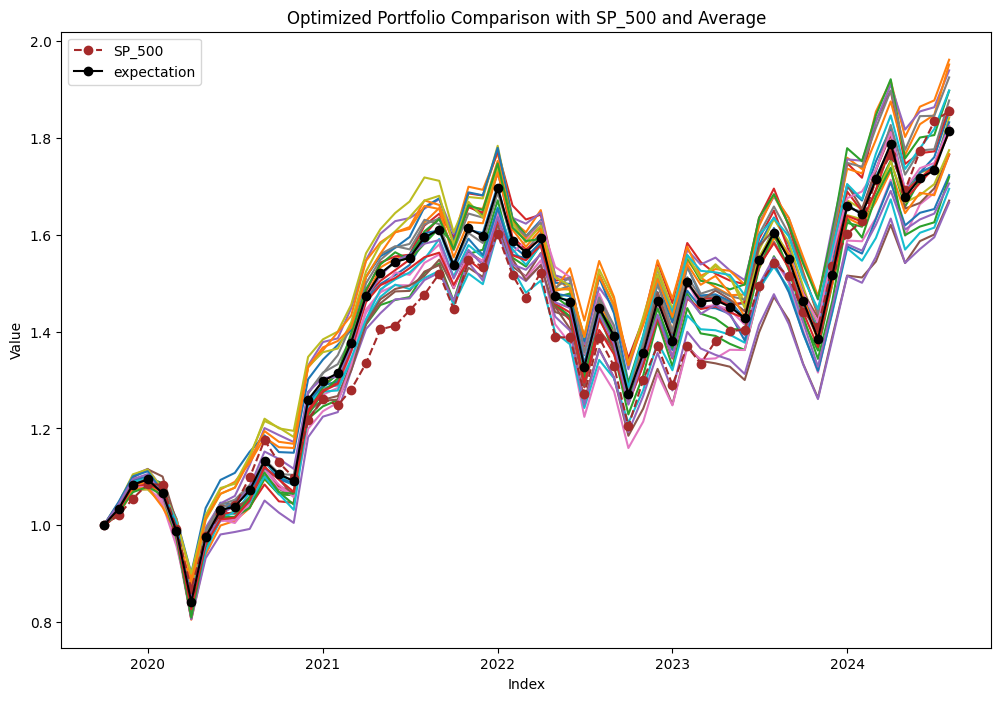

In [42]:
final_visual()#100


In [123]:
oos1_list,oos1_list_yearly,oos1_average=monte_carlo_simulation(5,1,1,0)

[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/89081000798a45f4b9cc376c70900a2d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/89081000798a45f4b9cc376c70900a2d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c726cb4c650d4d09aceba80550df9092-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c726cb4c650d4d09aceba80550df9092-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.2953 - 0.11 seconds
Cgl0004I processed model has 1242 rows, 659 columns (0 integer (0 of which binary)) and 32879 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.2953 to -1.79769e+308
Pro

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/864fab5e507f406fad4ca9c5840e54d3-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/864fab5e507f406fad4ca9c5840e54d3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.6962 - 0.12 seconds
Cgl0004I processed model has 1266 rows, 671 columns (0 integer (0 of which binary)) and 33527 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.6962 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2b151058f8a64289b82a5b745b37bb9d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2b151058f8a64289b82a5b745b37bb9d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.1374 - 0.12 seconds
Cgl0004I processed model has 1290 rows, 683 columns (0 integer (0 of which binary)) and 34175 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.1374 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/859a89c2ef7c43149adeb1a798ded477-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/859a89c2ef7c43149adeb1a798ded477-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.612 - 0.12 seconds
Cgl0004I processed model has 1314 rows, 695 columns (0 integer (0 of which binary)) and 34823 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.612 to -1.79769e+308
Probi

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a099a6dbcfe240979d9761c1ebf2802a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a099a6dbcfe240979d9761c1ebf2802a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.0046 - 0.16 seconds
Cgl0004I processed model has 1338 rows, 707 columns (0 integer (0 of which binary)) and 35471 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.0046 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1e31d2d6942543189bca5da5fd5983c7-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1e31d2d6942543189bca5da5fd5983c7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/25a67d54d2fc48199dd17ee04d413d31-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/25a67d54d2fc48199dd17ee04d413d31-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.2953 - 0.11 seconds
Cgl0004I processed model has 1242 rows, 659 columns (0 integer (0 of which binary)) and 32879 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.2953 to -1.79769e+308
Pro

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/187c6b40c8a34e99835e5eb928733840-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/187c6b40c8a34e99835e5eb928733840-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.6962 - 0.12 seconds
Cgl0004I processed model has 1266 rows, 671 columns (0 integer (0 of which binary)) and 33527 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.6962 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/8b1172df4f9a438690b3aee9779cfbd4-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/8b1172df4f9a438690b3aee9779cfbd4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.1374 - 0.12 seconds
Cgl0004I processed model has 1290 rows, 683 columns (0 integer (0 of which binary)) and 34175 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.1374 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/182fd26234fd4f7b948c9ab7db648a7c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/182fd26234fd4f7b948c9ab7db648a7c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.612 - 0.12 seconds
Cgl0004I processed model has 1314 rows, 695 columns (0 integer (0 of which binary)) and 34823 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.612 to -1.79769e+308
Probi

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/21787ce089714ad288859770eafde0e8-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/21787ce089714ad288859770eafde0e8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.0046 - 0.13 seconds
Cgl0004I processed model has 1338 rows, 707 columns (0 integer (0 of which binary)) and 35471 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.0046 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/93bf98185e7046dea7de934d46da6233-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/93bf98185e7046dea7de934d46da6233-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/6c541f1bdf4841f6a6c556fd903203ef-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/6c541f1bdf4841f6a6c556fd903203ef-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.2953 - 0.11 seconds
Cgl0004I processed model has 1242 rows, 659 columns (0 integer (0 of which binary)) and 32879 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.2953 to -1.79769e+308
Pro

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4523308d153c40fdb5344c6766feaa4b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4523308d153c40fdb5344c6766feaa4b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.6962 - 0.11 seconds
Cgl0004I processed model has 1266 rows, 671 columns (0 integer (0 of which binary)) and 33527 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.6962 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/472fd762546646b18aef4755326a2786-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/472fd762546646b18aef4755326a2786-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.1374 - 0.11 seconds
Cgl0004I processed model has 1290 rows, 683 columns (0 integer (0 of which binary)) and 34175 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.1374 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/dbe1bbcf197b4409bd7961d1c2a08ff3-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/dbe1bbcf197b4409bd7961d1c2a08ff3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.612 - 0.12 seconds
Cgl0004I processed model has 1314 rows, 695 columns (0 integer (0 of which binary)) and 34823 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.612 to -1.79769e+308
Probi

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/282ee604766d41f88bdac3cba36b9ae0-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/282ee604766d41f88bdac3cba36b9ae0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.0046 - 0.13 seconds
Cgl0004I processed model has 1338 rows, 707 columns (0 integer (0 of which binary)) and 35471 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.0046 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a18dd68291ab493097efdd80fc415f01-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a18dd68291ab493097efdd80fc415f01-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c20beec98e324ea289cb2e0438e9f54d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c20beec98e324ea289cb2e0438e9f54d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.2953 - 0.11 seconds
Cgl0004I processed model has 1242 rows, 659 columns (0 integer (0 of which binary)) and 32879 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.2953 to -1.79769e+308
Pro

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/037c1504dff6406c9d64cf50653beaf7-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/037c1504dff6406c9d64cf50653beaf7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.6962 - 0.14 seconds
Cgl0004I processed model has 1266 rows, 671 columns (0 integer (0 of which binary)) and 33527 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.6962 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/12a145a12e9d4f7ba9b3c4ace2fa060e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/12a145a12e9d4f7ba9b3c4ace2fa060e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.1374 - 0.12 seconds
Cgl0004I processed model has 1290 rows, 683 columns (0 integer (0 of which binary)) and 34175 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.1374 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3aaa03bbcf334d9ba40033d3f4a9488c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3aaa03bbcf334d9ba40033d3f4a9488c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.612 - 0.12 seconds
Cgl0004I processed model has 1314 rows, 695 columns (0 integer (0 of which binary)) and 34823 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.612 to -1.79769e+308
Probi

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/b43abcfc22754702bfe79d254336b741-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/b43abcfc22754702bfe79d254336b741-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.0046 - 0.13 seconds
Cgl0004I processed model has 1338 rows, 707 columns (0 integer (0 of which binary)) and 35471 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.0046 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/be3b9a472a81416484281ee12f3826e2-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/be3b9a472a81416484281ee12f3826e2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
['GEV']: ChunkedEncodingError(ProtocolError("Connection broken: InvalidChunkLength(got length b'', 0 bytes read)", InvalidChunkLength(got length b'', 0 bytes read)))
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c27a01c9758745d29984724a0074c78c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c27a01c9758745d29984724a0074c78c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.2953 - 0.12 seconds
Cgl0004I processed model has 1242 rows, 659 columns (0 integer (0 of which binary)) and 32879 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.2953 to -1.79769e+308
Pro

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/f3f54627ad464fa99611897cb4eb99f0-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/f3f54627ad464fa99611897cb4eb99f0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.6962 - 0.12 seconds
Cgl0004I processed model has 1266 rows, 671 columns (0 integer (0 of which binary)) and 33527 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 16.6962 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3792f7fcb87c4bf385ceb1e7bd879caf-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3792f7fcb87c4bf385ceb1e7bd879caf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.1374 - 0.11 seconds
Cgl0004I processed model has 1290 rows, 683 columns (0 integer (0 of which binary)) and 34175 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.1374 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1c5f6809e7754872a25752bf0d38c532-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1c5f6809e7754872a25752bf0d38c532-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.612 - 0.12 seconds
Cgl0004I processed model has 1314 rows, 695 columns (0 integer (0 of which binary)) and 34823 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.612 to -1.79769e+308
Probi

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7ffd9334ecf34ff4a4e8afcc0d7a72af-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7ffd9334ecf34ff4a4e8afcc0d7a72af-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.0046 - 0.13 seconds
Cgl0004I processed model has 1338 rows, 707 columns (0 integer (0 of which binary)) and 35471 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.0046 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed


In [143]:
oos1_list,oos1_list_yearly,oos1_average=monte_carlo_simulation(3,1,1,1)

[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1d6e99896de343ce99b5a1afc7d5901f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1d6e99896de343ce99b5a1afc7d5901f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.182915 - 0.03 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 22 integ

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/f63de4fb7bb9488fb18453d5b8e80891-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/f63de4fb7bb9488fb18453d5b8e80891-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.5719 - 0.11 seconds
Cgl0004I processed model has 1241 rows, 659 columns (0 integer (0 of which binary)) and 32852 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.5719 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7a9ded2baa7c48fc8ac69c88a69fec84-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7a9ded2baa7c48fc8ac69c88a69fec84-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.9202 - 0.11 seconds
Cgl0004I processed model has 1265 rows, 671 columns (0 integer (0 of which binary)) and 33500 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.9202 to -1.79769e+308
Pro

[*********************100%%**********************]  16 of 16 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2d7c2472b50b4d949326fa1da6e00b62-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2d7c2472b50b4d949326fa1da6e00b62-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.1384 - 0.12 seconds
Cgl0004I processed model has 1289 rows, 683 columns (0 integer (0 of which binary)) and 34148 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.1384 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/6a8d311d0c4a4ac9b31cbf57657c1014-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/6a8d311d0c4a4ac9b31cbf57657c1014-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.5297 - 0.19 seconds
Cgl0004I processed model has 1313 rows, 695 columns (0 integer (0 of which binary)) and 34796 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.5297 to -1.79769e+308
Pro

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/13d6f40720c9463e985d2467a29b239b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/13d6f40720c9463e985d2467a29b239b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 19.1233 - 0.13 seconds
Cgl0004I processed model has 1337 rows, 707 columns (0 integer (0 of which binary)) and 35444 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 19.1233 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/703cd93bd12b4987bfc848979873b230-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/703cd93bd12b4987bfc848979873b230-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.184096 - 0.03 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 22 integ

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/0b1184743ccc48428779fd7f8fd730a3-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/0b1184743ccc48428779fd7f8fd730a3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.5719 - 0.10 seconds
Cgl0004I processed model has 1241 rows, 659 columns (0 integer (0 of which binary)) and 32852 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.5719 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3297b944e20543eba266a8f182250dbe-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3297b944e20543eba266a8f182250dbe-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.9202 - 0.10 seconds
Cgl0004I processed model has 1265 rows, 671 columns (0 integer (0 of which binary)) and 33500 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.9202 to -1.79769e+308
Pro

[*********************100%%**********************]  16 of 16 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e35cec9810d943e0979b605949bf6b19-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e35cec9810d943e0979b605949bf6b19-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.1384 - 0.11 seconds
Cgl0004I processed model has 1289 rows, 683 columns (0 integer (0 of which binary)) and 34148 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.1384 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c71efa7845e5461f8c23d7c1b277d184-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c71efa7845e5461f8c23d7c1b277d184-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.5297 - 0.11 seconds
Cgl0004I processed model has 1313 rows, 695 columns (0 integer (0 of which binary)) and 34796 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.5297 to -1.79769e+308
Pro

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/162865f718f8437894af8a6e2b9dc509-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/162865f718f8437894af8a6e2b9dc509-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 19.1233 - 0.13 seconds
Cgl0004I processed model has 1337 rows, 707 columns (0 integer (0 of which binary)) and 35444 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 19.1233 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2f5ee5ba01ec456bb3b37b3e9fcea224-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2f5ee5ba01ec456bb3b37b3e9fcea224-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.184096 - 0.04 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 22 integ

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7ec3e7f8f7414e1aa9efd14b99839be6-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7ec3e7f8f7414e1aa9efd14b99839be6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.5719 - 0.12 seconds
Cgl0004I processed model has 1241 rows, 659 columns (0 integer (0 of which binary)) and 32852 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.5719 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4bfdad6aacd04b00a6c186157798e1cb-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4bfdad6aacd04b00a6c186157798e1cb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.9202 - 0.12 seconds
Cgl0004I processed model has 1265 rows, 671 columns (0 integer (0 of which binary)) and 33500 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 17.9202 to -1.79769e+308
Pro

[*********************100%%**********************]  16 of 16 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d7a81318d3a24eb79f4ef71b666a5898-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d7a81318d3a24eb79f4ef71b666a5898-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.1384 - 0.10 seconds
Cgl0004I processed model has 1289 rows, 683 columns (0 integer (0 of which binary)) and 34148 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.1384 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4c87c2f2d5aa46f8aaca0880008d444f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4c87c2f2d5aa46f8aaca0880008d444f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 18.5297 - 0.10 seconds
Cgl0004I processed model has 1313 rows, 695 columns (0 integer (0 of which binary)) and 34796 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 18.5297 to -1.79769e+308
Pro

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/dc874a54bdf84f4da62203d270c3e0fb-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/dc874a54bdf84f4da62203d270c3e0fb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 19.1233 - 0.12 seconds
Cgl0004I processed model has 1337 rows, 707 columns (0 integer (0 of which binary)) and 35444 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 19.1233 to -1.79769e+308
Pro

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed


In [145]:
oos1_list_yearly

[{1: 0.8446548438613134,
  2: 1.3562797157141055,
  3: 1.320235542360181,
  4: 1.5578301410029856,
  5: 1.9742766937025449},
 {1: 0.8446548438613134,
  2: 1.3562797157141055,
  3: 1.320235542360181,
  4: 1.5578301410029856,
  5: 1.9742766937025449},
 {1: 0.8446548438613134,
  2: 1.3562797157141055,
  3: 1.320235542360181,
  4: 1.5578301410029856,
  5: 1.9742766937025449}]

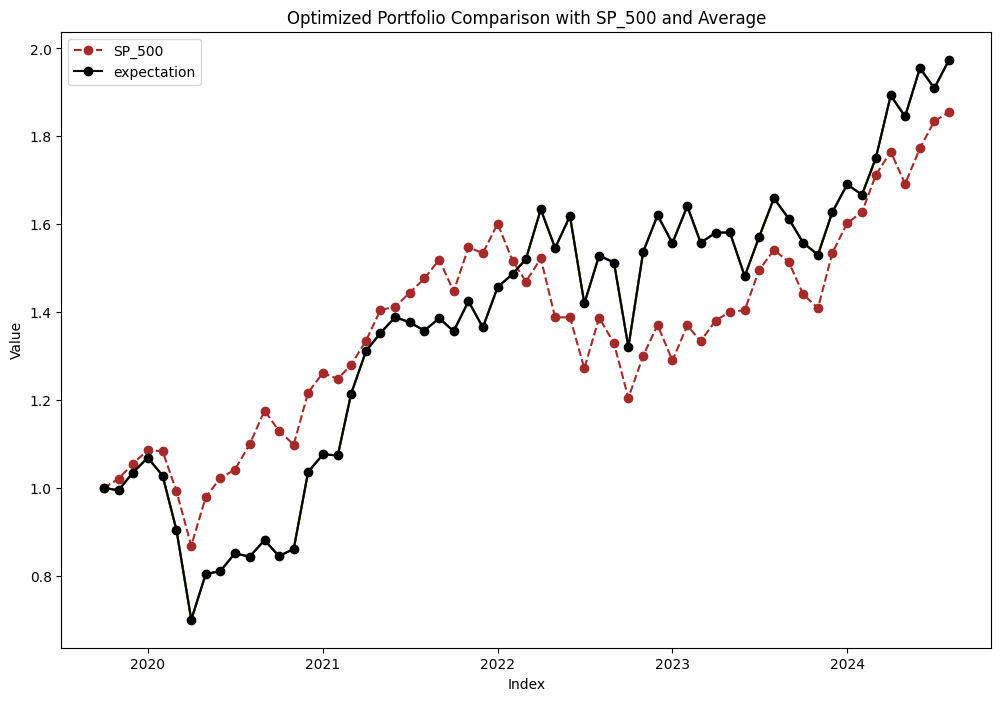

In [144]:
final_visual()

In [129]:
oos1_list,oos1_list_yearly,oos1_average=monte_carlo_simulation(3,1.5,0,0)

[*********************100%%**********************]  501 of 501 completed

23 Failed downloads:
['IT', 'BKR', 'F', 'COR', 'KEYS', 'CVS', 'WTW']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
['KVUE', 'DRI', 'KR']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))
['VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  464 of 464 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/ed03d1d0e3e04b49b1ff9ddc8f44dfcd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/ed03d1d0e3e04b49b1ff9ddc8f44dfcd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2399 COLUMNS
At line 42409 RHS
At line 44804 BOUNDS
At line 45269 ENDATA
Problem MODEL has 2394 rows, 2355 columns and 39046 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1002 rows, 1427 columns (464 integer (464 of which binary)) and 36262 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.30358 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/62aebc2935f840b194db38a63322ab49-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/62aebc2935f840b194db38a63322ab49-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.224 - 0.13 seconds
Cgl0004I processed model has 1243 rows, 659 columns (0 integer (0 of which binary)) and 32906 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 13.224 to -1.79769e+308
Probi

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/475a30bf67e34f448ec5cf9c622e0df1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/475a30bf67e34f448ec5cf9c622e0df1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.6136 - 0.13 seconds
Cgl0004I processed model has 1267 rows, 671 columns (0 integer (0 of which binary)) and 33554 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 13.6136 to -1.79769e+308
Pro

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3a8f51bf031a4df6aff09d99eb8f9ad9-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3a8f51bf031a4df6aff09d99eb8f9ad9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.0819 - 0.14 seconds
Cgl0004I processed model has 1291 rows, 683 columns (0 integer (0 of which binary)) and 34202 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 14.0819 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e4f4a52bf5ce4cc196fa0cb4b35b2429-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e4f4a52bf5ce4cc196fa0cb4b35b2429-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.4054 - 0.15 seconds
Cgl0004I processed model has 1315 rows, 695 columns (0 integer (0 of which binary)) and 34850 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 14.4054 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/49a519d3d0024d47acac686014b40af9-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/49a519d3d0024d47acac686014b40af9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.7481 - 0.15 seconds
Cgl0004I processed model has 1339 rows, 707 columns (0 integer (0 of which binary)) and 35498 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 14.7481 to -1.79769e+308
Pro

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/8dd93fe7c9f947908e21d0c65ffb56df-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/8dd93fe7c9f947908e21d0c65ffb56df-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.24899 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e5995db9ecbc4af7b6e3a187e690bd83-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e5995db9ecbc4af7b6e3a187e690bd83-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.224 - 0.13 seconds
Cgl0004I processed model has 1243 rows, 659 columns (0 integer (0 of which binary)) and 32906 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 13.224 to -1.79769e+308
Probi

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a16c19e270c14281a109de1efc6c70f5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a16c19e270c14281a109de1efc6c70f5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.6136 - 0.15 seconds
Cgl0004I processed model has 1267 rows, 671 columns (0 integer (0 of which binary)) and 33554 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 13.6136 to -1.79769e+308
Pro

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/638e62a6b61141e9b52bba76f37ca226-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/638e62a6b61141e9b52bba76f37ca226-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.0819 - 0.15 seconds
Cgl0004I processed model has 1291 rows, 683 columns (0 integer (0 of which binary)) and 34202 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 14.0819 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/823a8c4e7c9e4c5ca363ee1d47727bea-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/823a8c4e7c9e4c5ca363ee1d47727bea-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.4054 - 0.15 seconds
Cgl0004I processed model has 1315 rows, 695 columns (0 integer (0 of which binary)) and 34850 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 14.4054 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d0e6bdeb1c1d4efc986d317db9188d27-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d0e6bdeb1c1d4efc986d317db9188d27-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.7481 - 0.16 seconds
Cgl0004I processed model has 1339 rows, 707 columns (0 integer (0 of which binary)) and 35498 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 14.7481 to -1.79769e+308
Pro

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/01fc492b736247a786565e844c88b14c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/01fc492b736247a786565e844c88b14c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.24899 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/95fc718770ac432a8f9c75c930903ed1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/95fc718770ac432a8f9c75c930903ed1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.224 - 0.13 seconds
Cgl0004I processed model has 1243 rows, 659 columns (0 integer (0 of which binary)) and 32906 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 13.224 to -1.79769e+308
Probi

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4366fb8cc69c45a9bfb845d6496d0471-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4366fb8cc69c45a9bfb845d6496d0471-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.6136 - 0.13 seconds
Cgl0004I processed model has 1267 rows, 671 columns (0 integer (0 of which binary)) and 33554 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 13.6136 to -1.79769e+308
Pro

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/0a12b16617544f0c8f8c7d427b9e6a33-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/0a12b16617544f0c8f8c7d427b9e6a33-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.0819 - 0.14 seconds
Cgl0004I processed model has 1291 rows, 683 columns (0 integer (0 of which binary)) and 34202 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 14.0819 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/9257f105101244c9bccdbc94deb57eb5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/9257f105101244c9bccdbc94deb57eb5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.4054 - 0.15 seconds
Cgl0004I processed model has 1315 rows, 695 columns (0 integer (0 of which binary)) and 34850 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 14.4054 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7a0b8e7a551940959f94f019354f6604-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7a0b8e7a551940959f94f019354f6604-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 14.7481 - 0.15 seconds
Cgl0004I processed model has 1339 rows, 707 columns (0 integer (0 of which binary)) and 35498 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 14.7481 to -1.79769e+308
Pro

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed


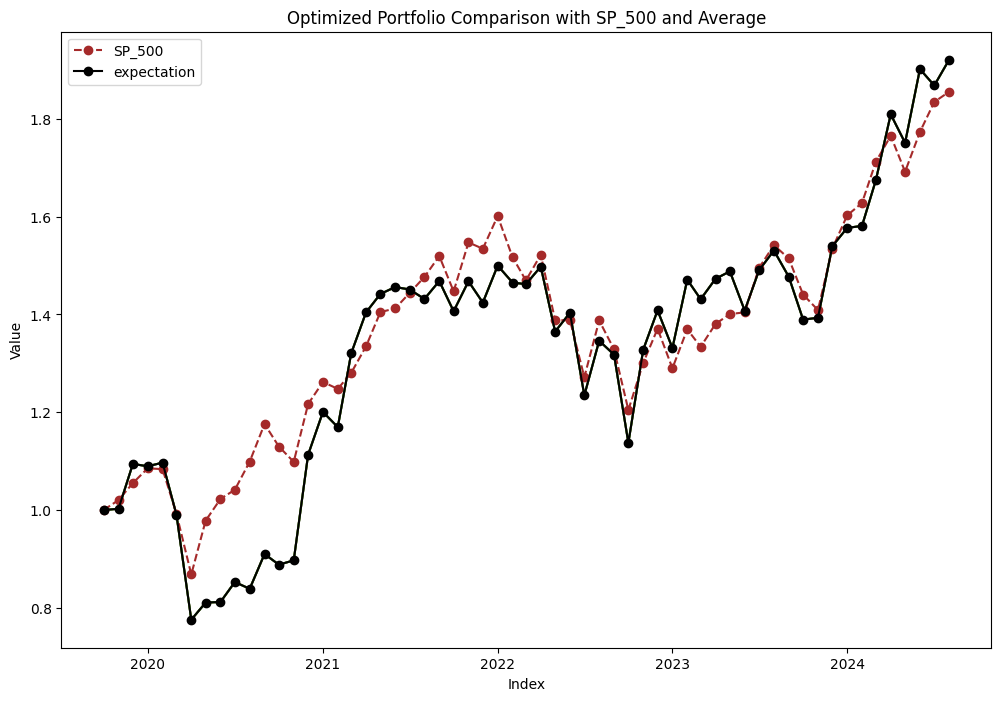

In [151]:
final_visual(oos1_list)

In [148]:
oos1_average

{1: 0.8883254000964392,
 2: 1.4064823395241752,
 3: 1.1373022341373276,
 4: 1.3892320606095059,
 5: 1.9206664998051932}

In [146]:
oos1_list,oos1_list_yearly,oos1_average=monte_carlo_simulation(3,2,0,0)

[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
['GEV']: ChunkedEncodingError(ProtocolError("Connection broken: InvalidChunkLength(got length b'', 0 bytes read)", InvalidChunkLength(got length b'', 0 bytes read)))
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/59221c2fabaf486e899cb7b5e26a548a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/59221c2fabaf486e899cb7b5e26a548a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.14874 - 0.16 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 25 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.595

[*********************100%%**********************]  25 of 25 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/993588e5be4b4e058b49481bbad39fa6-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/993588e5be4b4e058b49481bbad39fa6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 21.14 - 0.14 seconds
Cgl0004I processed model has 1243 rows, 659 columns (0 integer (0 of which binary)) and 32906 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 21.14 to -1.79769e+308
Probing

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/02183f1315324be4a49f1294efcbebf8-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/02183f1315324be4a49f1294efcbebf8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 21.5814 - 0.13 seconds
Cgl0004I processed model has 1267 rows, 671 columns (0 integer (0 of which binary)) and 33554 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 21.5814 to -1.79769e+308
Pro

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/0669c6b33618422dbfccf5a2f8e40457-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/0669c6b33618422dbfccf5a2f8e40457-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22.2746 - 0.14 seconds
Cgl0004I processed model has 1291 rows, 683 columns (0 integer (0 of which binary)) and 34202 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 22.2746 to -1.79769e+308
Pro

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/6bd37cecc4be40c28aa0aec85c225941-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/6bd37cecc4be40c28aa0aec85c225941-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22.73 - 0.16 seconds
Cgl0004I processed model has 1315 rows, 695 columns (0 integer (0 of which binary)) and 34850 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 22.73 to -1.79769e+308
Probing

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/8413895009b44633a1783fe18399a924-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/8413895009b44633a1783fe18399a924-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 23.2399 - 0.19 seconds
Cgl0004I processed model has 1339 rows, 707 columns (0 integer (0 of which binary)) and 35498 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 23.2399 to -1.79769e+308
Pro

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7cc75eaf39fd4163836f78b8583b5079-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7cc75eaf39fd4163836f78b8583b5079-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.128432 - 0.08 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 28 integ

[*********************100%%**********************]  28 of 28 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['PLTR', 'KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/152ff9f68e66497889db918c53e9cdce-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/152ff9f68e66497889db918c53e9cdce-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 21.14 - 0.14 seconds
Cgl0004I processed model has 1243 rows, 659 columns (0 integer (0 of which binary)) and 32906 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 21.14 to -1.79769e+308
Probing

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/92d8902054a0439093ddc220704534b1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/92d8902054a0439093ddc220704534b1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 21.5814 - 0.14 seconds
Cgl0004I processed model has 1267 rows, 671 columns (0 integer (0 of which binary)) and 33554 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 21.5814 to -1.79769e+308
Pro

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a898cc46f6a24f39bf4fbec3ae618ad5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a898cc46f6a24f39bf4fbec3ae618ad5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22.2746 - 0.15 seconds
Cgl0004I processed model has 1291 rows, 683 columns (0 integer (0 of which binary)) and 34202 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 22.2746 to -1.79769e+308
Pro

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/538ffd2175214538a1dbaf6177609c99-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/538ffd2175214538a1dbaf6177609c99-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22.73 - 0.14 seconds
Cgl0004I processed model has 1315 rows, 695 columns (0 integer (0 of which binary)) and 34850 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 22.73 to -1.79769e+308
Probing

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/6a2d2748d76f4b00a63e4032a9272a94-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/6a2d2748d76f4b00a63e4032a9272a94-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 23.2399 - 0.16 seconds
Cgl0004I processed model has 1339 rows, 707 columns (0 integer (0 of which binary)) and 35498 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 23.2399 to -1.79769e+308
Pro

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4d6e0e7bee594f7ba581074a5a35724c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4d6e0e7bee594f7ba581074a5a35724c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.128432 - 0.09 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 28 integ

[*********************100%%**********************]  28 of 28 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7e1b665974914b668f6e47c212b3a100-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/7e1b665974914b668f6e47c212b3a100-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 21.14 - 0.13 seconds
Cgl0004I processed model has 1243 rows, 659 columns (0 integer (0 of which binary)) and 32906 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 21.14 to -1.79769e+308
Probing

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/933c55aa34784db3b910229be1a37ca1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/933c55aa34784db3b910229be1a37ca1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 21.5814 - 0.15 seconds
Cgl0004I processed model has 1267 rows, 671 columns (0 integer (0 of which binary)) and 33554 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 21.5814 to -1.79769e+308
Pro

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/805da8108a86438c8c91b2383f2d1c98-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/805da8108a86438c8c91b2383f2d1c98-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22.2746 - 0.17 seconds
Cgl0004I processed model has 1291 rows, 683 columns (0 integer (0 of which binary)) and 34202 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 22.2746 to -1.79769e+308
Pro

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/79da5b4d8abc4a0ca619b2b036eb7320-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/79da5b4d8abc4a0ca619b2b036eb7320-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22.73 - 0.16 seconds
Cgl0004I processed model has 1315 rows, 695 columns (0 integer (0 of which binary)) and 34850 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 22.73 to -1.79769e+308
Probing

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/6768bd20670142cb8a614aeac0b18ec2-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/6768bd20670142cb8a614aeac0b18ec2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 23.2399 - 0.15 seconds
Cgl0004I processed model has 1339 rows, 707 columns (0 integer (0 of which binary)) and 35498 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 23.2399 to -1.79769e+308
Pro

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  1 of 1 completed


In [133]:
oos1_list,oos1_list_yearly,oos1_average=monte_carlo_simulation(3,1,0,1)

[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/dbfe211c495146cfaea0ddbfe84c5f5c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/dbfe211c495146cfaea0ddbfe84c5f5c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.0370871 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 32 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.5

[*********************100%%**********************]  32 of 32 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/51e5a544ae19438aa0dca961eb804013-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/51e5a544ae19438aa0dca961eb804013-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 11.6745 - 0.11 seconds
Cgl0004I processed model has 1243 rows, 659 columns (0 integer (0 of which binary)) and 32906 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 11.6745 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a69e759da10f4c41b843368e743f74a4-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a69e759da10f4c41b843368e743f74a4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 11.9042 - 0.13 seconds
Cgl0004I processed model has 1267 rows, 671 columns (0 integer (0 of which binary)) and 33554 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 11.9042 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/cb125c8a37d142548b9bc3f8e9465458-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/cb125c8a37d142548b9bc3f8e9465458-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.1826 - 0.13 seconds
Cgl0004I processed model has 1291 rows, 683 columns (0 integer (0 of which binary)) and 34202 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 12.1826 to -1.79769e+308
Pro

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c3369a117f504d44981b9080d97a2a23-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/c3369a117f504d44981b9080d97a2a23-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.4142 - 0.12 seconds
Cgl0004I processed model has 1315 rows, 695 columns (0 integer (0 of which binary)) and 34850 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 12.4142 to -1.79769e+308
Pro

[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e0a895355b98475e8f0426c553aa1aef-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e0a895355b98475e8f0426c553aa1aef-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.6923 - 0.15 seconds
Cgl0004I processed model has 1339 rows, 707 columns (0 integer (0 of which binary)) and 35498 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 12.6923 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'OTIS', 'GEV', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2a7ea1d1ce234c6296a3e40aad09f6bb-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2a7ea1d1ce234c6296a3e40aad09f6bb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.0368162 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 30 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.5

[*********************100%%**********************]  30 of 30 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/167527bbe2614e5ca909e997a8b3a1f6-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/167527bbe2614e5ca909e997a8b3a1f6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 11.6745 - 0.11 seconds
Cgl0004I processed model has 1243 rows, 659 columns (0 integer (0 of which binary)) and 32906 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 11.6745 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/00d8d1e17e184d8c9bf00526f00ea9b5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/00d8d1e17e184d8c9bf00526f00ea9b5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 11.9042 - 0.13 seconds
Cgl0004I processed model has 1267 rows, 671 columns (0 integer (0 of which binary)) and 33554 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 11.9042 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/f0d1bca14ff841a19c4de977d7fd0f30-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/f0d1bca14ff841a19c4de977d7fd0f30-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.1826 - 0.12 seconds
Cgl0004I processed model has 1291 rows, 683 columns (0 integer (0 of which binary)) and 34202 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 12.1826 to -1.79769e+308
Pro

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/5eb36e5ecb4340edab3ff6872fb87ad2-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/5eb36e5ecb4340edab3ff6872fb87ad2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.4142 - 0.13 seconds
Cgl0004I processed model has 1315 rows, 695 columns (0 integer (0 of which binary)) and 34850 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 12.4142 to -1.79769e+308
Pro

[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a0c41bc94aca412fb595d1e52c87d479-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/a0c41bc94aca412fb595d1e52c87d479-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.6923 - 0.13 seconds
Cgl0004I processed model has 1339 rows, 707 columns (0 integer (0 of which binary)) and 35498 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 12.6923 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  473 of 473 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/029f22e795ef4a2e91d9581134a71d04-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/029f22e795ef4a2e91d9581134a71d04-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.0368162 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 30 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.5

[*********************100%%**********************]  30 of 30 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

12 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'GEHC', 'ABNB', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1598760000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2020-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/37ec11dbbf6345fa9c0b38ed72885f20-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/37ec11dbbf6345fa9c0b38ed72885f20-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1353 COLUMNS
At line 35153 RHS
At line 36502 BOUNDS
At line 36529 ENDATA
Problem MODEL has 1348 rows, 737 columns and 33140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 11.6745 - 0.13 seconds
Cgl0004I processed model has 1243 rows, 659 columns (0 integer (0 of which binary)) and 32906 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 11.6745 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

10 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC', 'CEG']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1630468800")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2021-09-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2efa52ae43244478ad7b2f2a4b6febb7-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/2efa52ae43244478ad7b2f2a4b6febb7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1377 COLUMNS
At line 35837 RHS
At line 37210 BOUNDS
At line 37237 ENDATA
Problem MODEL has 1372 rows, 749 columns and 33788 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 11.9042 - 0.13 seconds
Cgl0004I processed model has 1267 rows, 671 columns (0 integer (0 of which binary)) and 33554 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 11.9042 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

9 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'SW', 'SOLV', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1661918400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2022-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/b1fb168cbbd0402ba6876e03ed53bb88-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/b1fb168cbbd0402ba6876e03ed53bb88-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1401 COLUMNS
At line 36521 RHS
At line 37918 BOUNDS
At line 37945 ENDATA
Problem MODEL has 1396 rows, 761 columns and 34436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.1826 - 0.13 seconds
Cgl0004I processed model has 1291 rows, 683 columns (0 integer (0 of which binary)) and 34202 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 12.1826 to -1.79769e+308
Pro

[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['VLTO', 'AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1693454400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2023-08-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d8554faec53d49cda9ca865d946e24ed-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d8554faec53d49cda9ca865d946e24ed-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1425 COLUMNS
At line 37205 RHS
At line 38626 BOUNDS
At line 38653 ENDATA
Problem MODEL has 1420 rows, 773 columns and 35084 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.4142 - 0.12 seconds
Cgl0004I processed model has 1315 rows, 695 columns (0 integer (0 of which binary)) and 34850 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 12.4142 to -1.79769e+308
Pro

[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

3 Failed downloads:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 3, endDate = 1724990400")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 3 -> 2024-08-30)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  26 of 26 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/b7f4601c2e5541f09e60739ea9f4c10b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/b7f4601c2e5541f09e60739ea9f4c10b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1449 COLUMNS
At line 37889 RHS
At line 39334 BOUNDS
At line 39361 ENDATA
Problem MODEL has 1444 rows, 785 columns and 35732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.6923 - 0.13 seconds
Cgl0004I processed model has 1339 rows, 707 columns (0 integer (0 of which binary)) and 35498 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 12.6923 to -1.79769e+308
Pro

[*********************100%%**********************]  21 of 21 completed
[*********************100%%**********************]  1 of 1 completed


In [141]:
oos1_average

{1: 0.8366622522470349,
 2: 1.2622889223449143,
 3: 1.2676337553301924,
 4: 1.5039115928440634,
 5: 1.907278974830304}

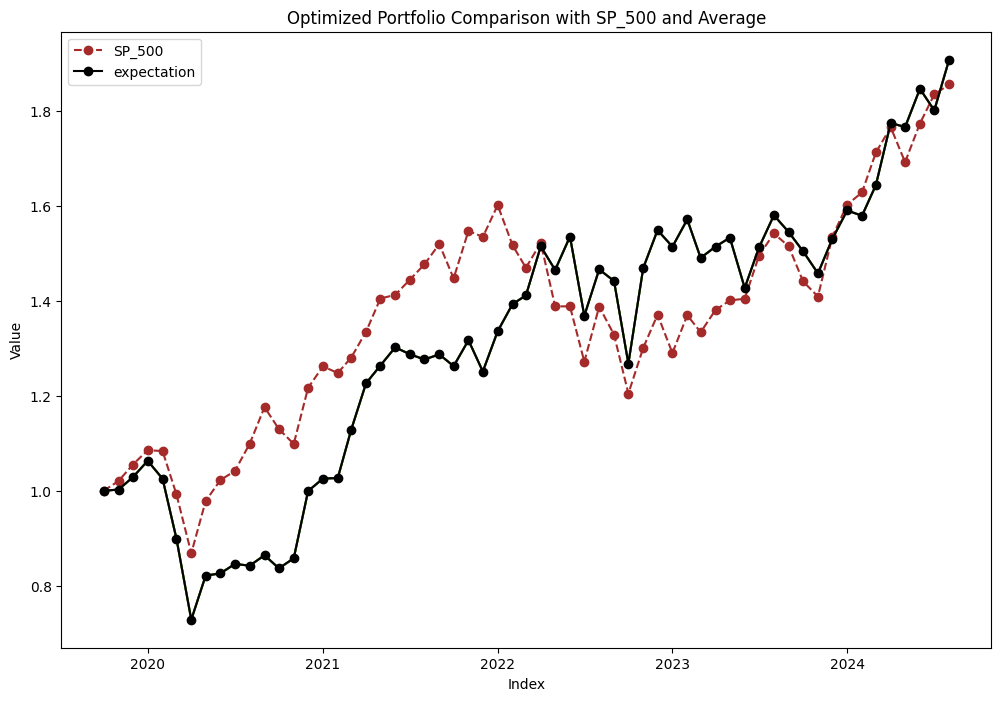

In [137]:
final_visual()

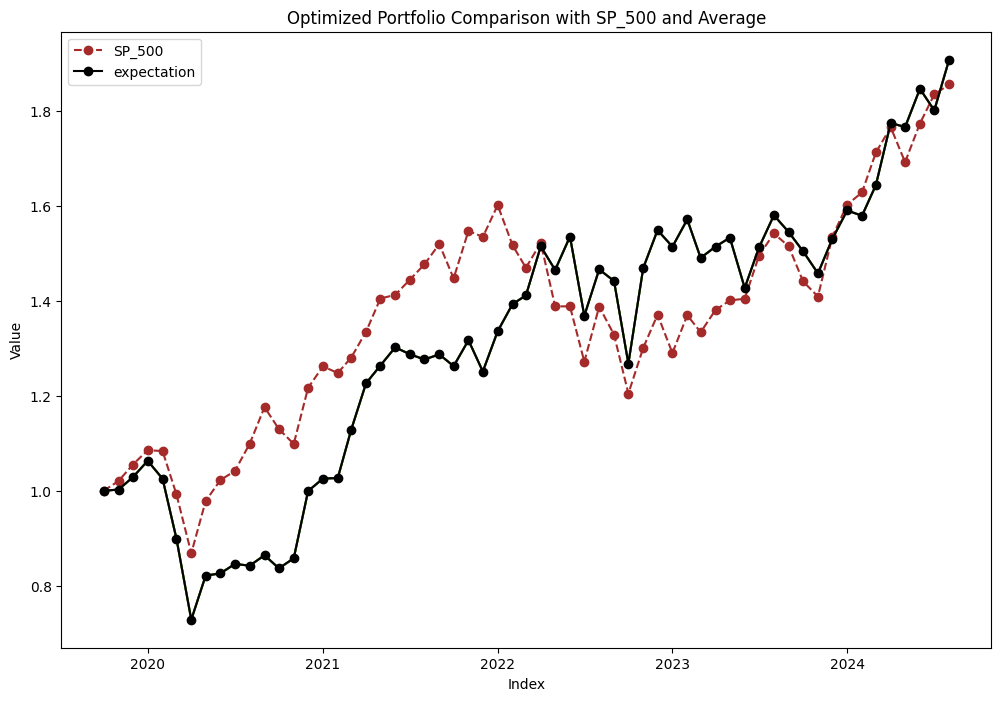

In [138]:
final_visual()

In [128]:
oos1_new_performance

Ticker,SP_500,Optimized Portfolio
Date,,
2022-10-01,1.000000,1.000000
2022-11-01,1.079863,1.169517
2022-12-01,1.137909,1.231664
2023-01-01,1.070805,1.175381
2023-02-01,1.136930,1.250425
2023-03-01,1.107242,1.210510
2023-04-01,1.146053,1.241771
2023-05-01,1.162834,1.261130
2023-06-01,1.165720,1.188173


In [124]:
oos1_average

{1: 0.8774984671125704,
 2: 1.325482750064125,
 3: 1.212586468754804,
 4: 1.3747267300892843,
 5: 1.7890384584241037}

In [60]:
oos1_list,oos1_list_yearly,oos1_average=monte_carlo_simulation(17,1,1,0)

[*********************100%%**********************]  501 of 501 completed

16 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CARR', 'GEHC', 'ABNB']: Exception("%ticker%: Data doesn't exist for startDate = 1472702400, endDate = 1567224000")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2016-09-01 -> 2019-08-31)')
['TDG', 'KMB', 'CEG']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  471 of 471 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3b67a7c883994a509432202e4179132b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/3b67a7c883994a509432202e4179132b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2434 COLUMNS
At line 43046 RHS
At line 45476 BOUNDS
At line 45948 ENDATA
Problem MODEL has 2429 rows, 2390 columns and 39634 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.08 seconds
Cgl0004I processed model has 1016 rows, 1448 columns (471 integer (471 of which binary)) and 36808 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.39033 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  35 of 36 completed

1 Failed download:
['GEN']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed

1 Failed download:
['MOS']: ReadTimeout(ReadTimeoutError("HTTPSConne

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/54e9dc91d5de443994dad641949d35b2-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/54e9dc91d5de443994dad641949d35b2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2439 COLUMNS
At line 43137 RHS
At line 45572 BOUNDS
At line 46045 ENDATA
Problem MODEL has 2434 rows, 2395 columns and 39718 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.04 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 1018 rows, 1451 columns (472 integer (472 of which binary)) and 36886 elements
Cbc0038I Initial state - 36 integers uns

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/9f5ec927ac8f4713bbe325f9903cce35-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/9f5ec927ac8f4713bbe325f9903cce35-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/02ba0e352dd04725a12416e7e45836c4-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/02ba0e352dd04725a12416e7e45836c4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/9f04b1063e7340c9aa32225398371ee3-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/9f04b1063e7340c9aa32225398371ee3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/86bfd382987e47f4bce9dd08b4917286-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/86bfd382987e47f4bce9dd08b4917286-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/96091c57c9df4fbf940425f7891af75d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/96091c57c9df4fbf940425f7891af75d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/bf1d2829c3b94ecba79dd383a13268d9-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/bf1d2829c3b94ecba79dd383a13268d9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/5e733c2e19de4dd9b7331e25f07a5d5d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/5e733c2e19de4dd9b7331e25f07a5d5d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/fed5b36faea64941ba5ecf6f727f2369-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/fed5b36faea64941ba5ecf6f727f2369-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e888c0062a7841c3afb6189a9f582e64-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/e888c0062a7841c3afb6189a9f582e64-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/fc31bad0671d49b68fe523e78e6e2e8a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/fc31bad0671d49b68fe523e78e6e2e8a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'OTIS', 'GEV', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4ce2bd3834d947108838a443387d195a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4ce2bd3834d947108838a443387d195a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4961e71d53e14779aa873a790a006e9a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/4961e71d53e14779aa873a790a006e9a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1fb6f9c0a973413bbab1449e92bc2ade-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/1fb6f9c0a973413bbab1449e92bc2ade-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/25a6ee922045481d87a40d249e33a0e0-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/25a6ee922045481d87a40d249e33a0e0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  501 of 501 completed

14 Failed downloads:
['KVUE', 'VLTO', 'AMTM', 'PLTR', 'SW', 'SOLV', 'GEV', 'OTIS', 'CA

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/acb0fba29b6c414a9af66b7291070758-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/acb0fba29b6c414a9af66b7291070758-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2444 COLUMNS
At line 43228 RHS
At line 45668 BOUNDS
At line 46142 ENDATA
Problem MODEL has 2439 rows, 2400 columns and 39802 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.04 seconds
Cgl0004I processed model has 1020 rows, 1454 columns (473 integer (473 of which binary)) and 36964 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.32099 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed


In [126]:
oos1_list

[Ticker        SP_500  Optimized Portfolio
 Date                                     
 2019-10-01  1.000000             1.000000
 2019-11-01  1.020432             0.979212
 2019-12-01  1.055174             1.031900
 2020-01-01  1.085342             1.046149
 2020-02-01  1.083575             1.035833
 2020-03-01  0.992435             0.929755
 2020-04-01  0.868262             0.735805
 2020-05-01  0.978396             0.813028
 2020-06-01  1.022699             0.819144
 2020-07-01  1.041505             0.859313
 2020-08-01  1.098893             0.855493
 2020-09-01  1.175887             0.913494
 2020-10-01  1.129759             0.877498
 2020-11-01  1.098504             0.876956
 2020-12-01  1.216643             1.045086
 2021-01-01  1.261807             1.097011
 2021-02-01  1.247754             1.081352
 2021-03-01  1.280310             1.200463
 2021-04-01  1.334645             1.297201
 2021-05-01  1.404614             1.329782
 2021-06-01  1.412320             1.345261
 2021-07-01

In [59]:
oos1_list

[Ticker        SP_500  Optimized Portfolio
 Date                                     
 2019-10-01  1.000000             1.000000
 2019-11-01  1.020432             1.031326
 2019-12-01  1.055174             1.091304
 2020-01-01  1.085342             1.147552
 2020-02-01  1.083575             1.122901
 2020-03-01  0.992435             1.064230
 2020-04-01  0.868262             0.831063
 2020-05-01  0.978396             1.068589
 2020-06-01  1.022699             1.094483
 2020-07-01  1.041505             1.120244
 2020-08-01  1.098893             1.137388
 2020-09-01  1.175887             1.199262
 2020-10-01  1.129759             1.139326
 2020-11-01  1.098504             1.138907
 2020-12-01  1.216643             1.391722
 2021-01-01  1.261807             1.464467
 2021-02-01  1.247754             1.529789
 2021-03-01  1.280310             1.665636
 2021-04-01  1.334645             1.703492
 2021-05-01  1.404614             1.771430
 2021-06-01  1.412320             1.797204
 2021-07-01

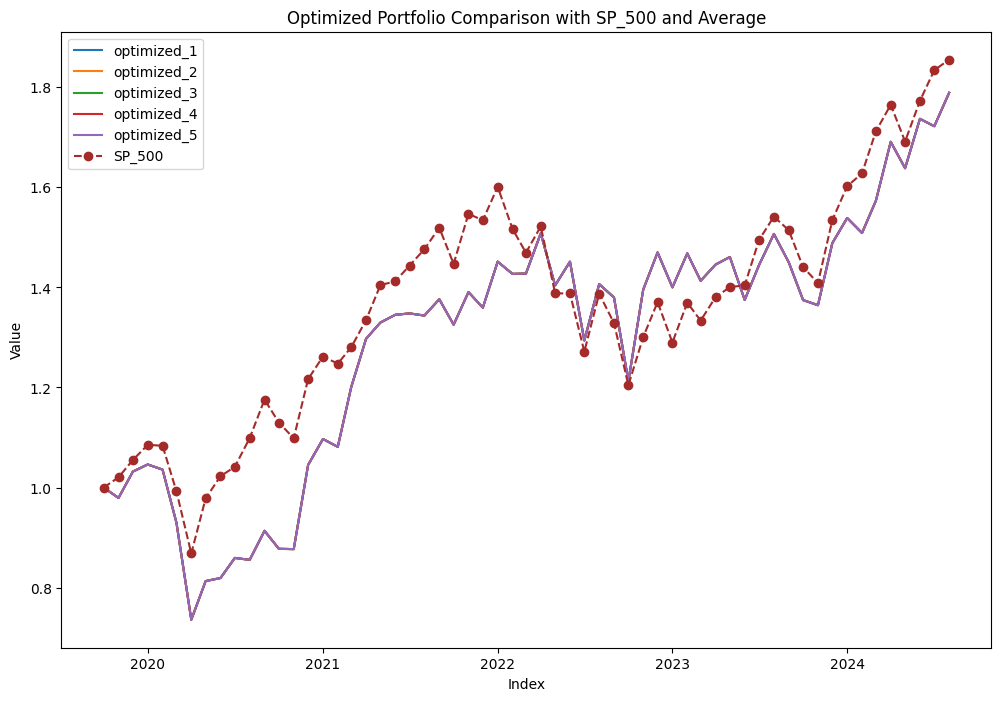

In [125]:
final_visual1()

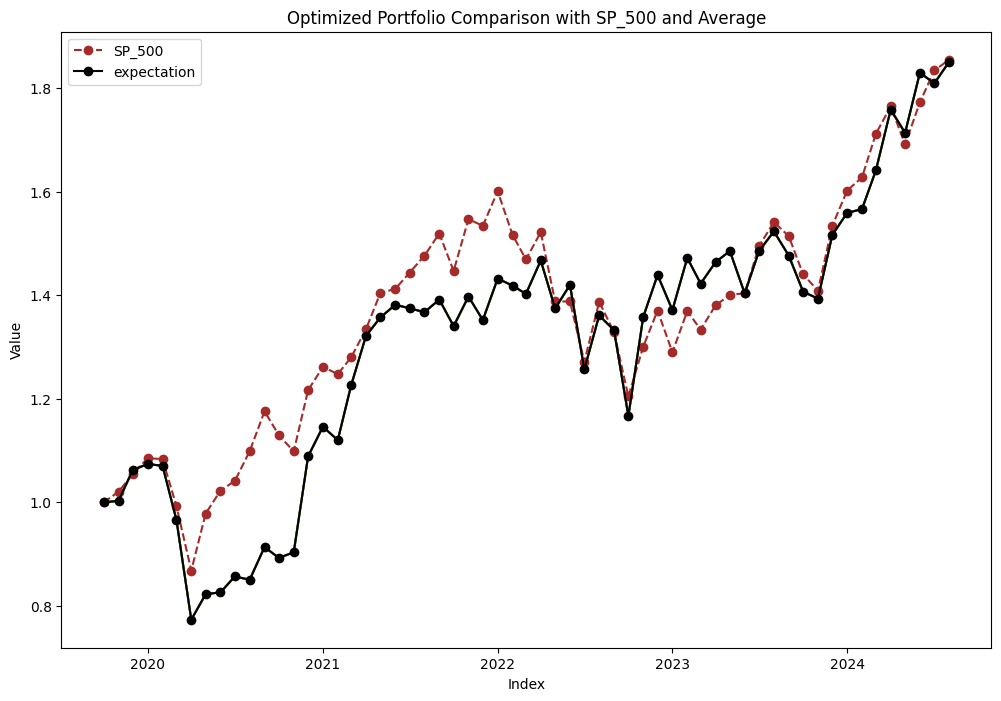

In [131]:
final_visual()

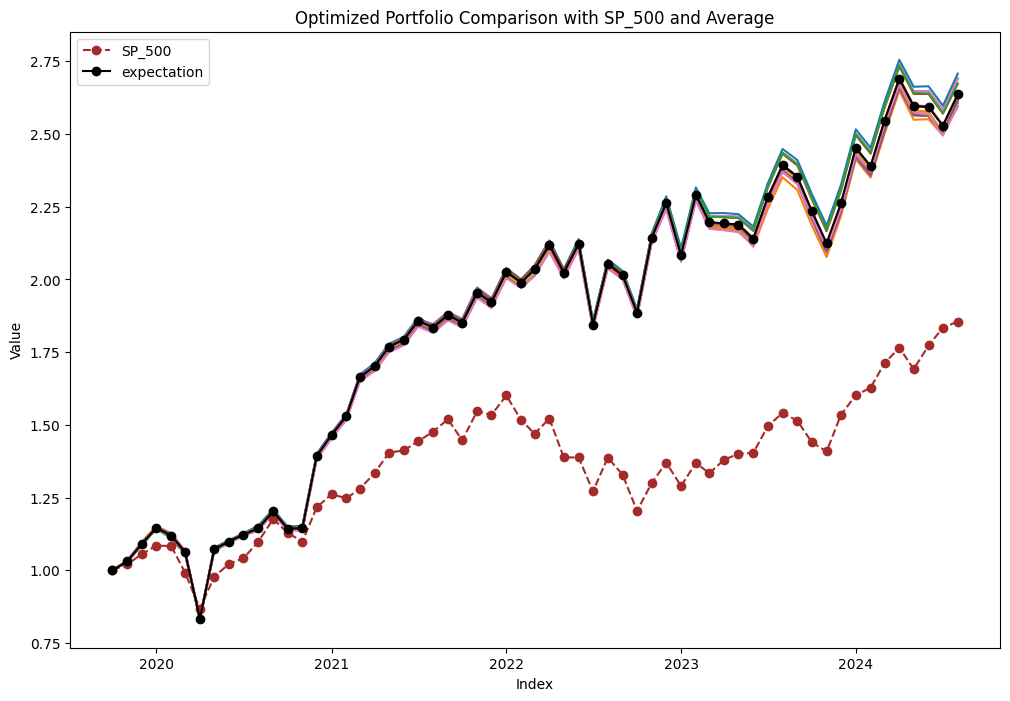

In [63]:
final_visual() #110

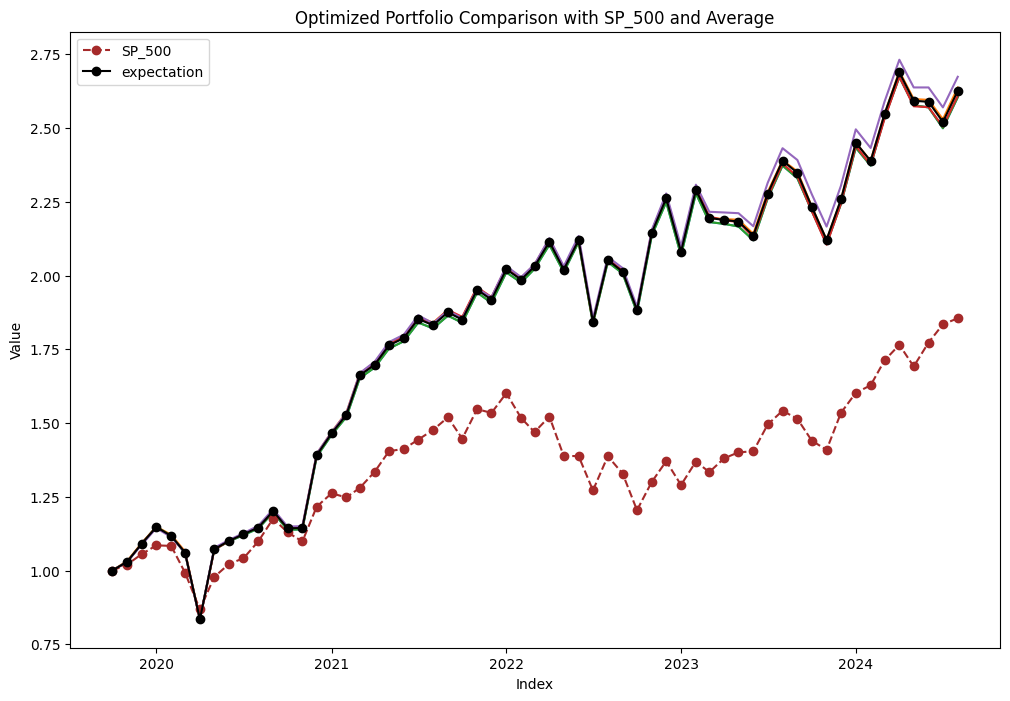

In [ ]:
final_visual() #110

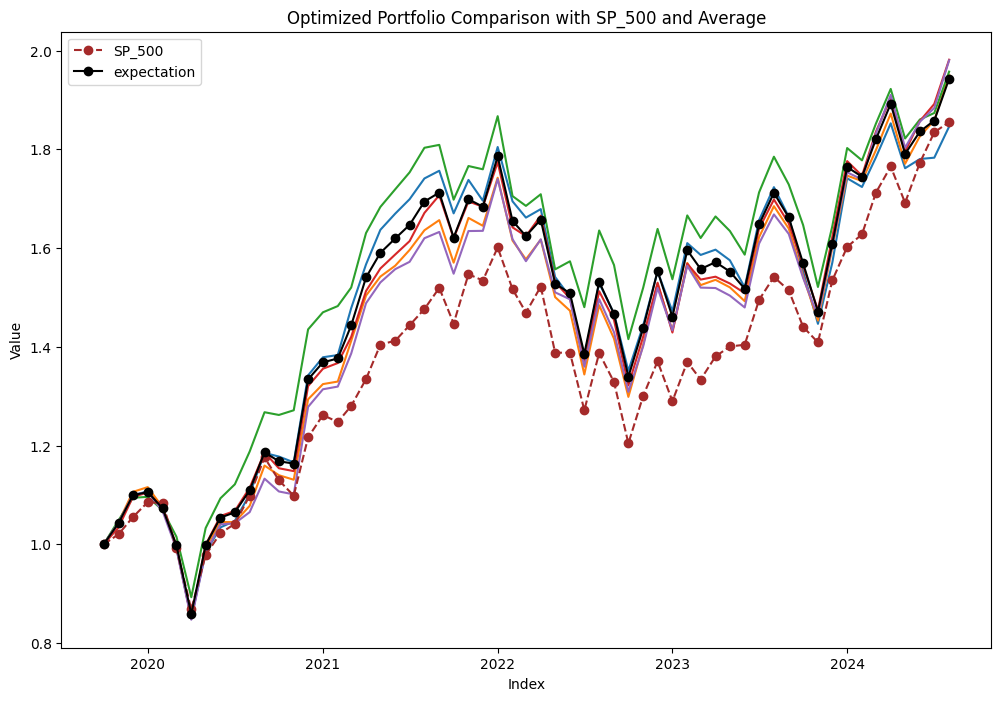

In [ ]:
final_visual() #010

In [27]:
def hedge_portfolio_beta(current_beta, target_beta, hedge_ratio, contrat_size, size_of_position, factor_weight, index_futures_price, hedge_period, index_multiple):
    factor_weight=round(0.99/hedge_ratio,1)
    if target_beta > current_beta:
        # If target beta is greater, take a long position
        number_of_contracts = (target_beta - current_beta) * (hedge_ratio * (factor_weight * size_of_position) / contrat_size)
        hedge_profit = number_of_contracts * (index_futures_price['Adj Close'].iloc[index_futures_price.index.get_loc(o1_start_d) + hedge_period + 1] - index_futures_price['Adj Close'].iloc[index_futures_price.index.get_loc(o1_start_d) + 1])
        opt_portf_profit = B * (oos1_new_performance.loc[str(index_futures_price.index[index_futures_price.index.get_loc(o1_start_d)+ hedge_period + 1]),'Optimized Portfolio'] - oos1_new_performance.loc[str(index_futures_price.index[index_futures_price.index.get_loc(o1_start_d)+1]),'Optimized Portfolio'])
        total_profit = opt_portf_profit + hedge_profit
        action = "LONG"
    elif target_beta < current_beta:
        # If target beta is smaller, take a short position
        number_of_contracts = (current_beta - target_beta) * (hedge_ratio * (factor_weight * size_of_position) / contrat_size)
        hedge_profit = number_of_contracts * (index_futures_price['Adj Close'].iloc[index_futures_price.index.get_loc(o1_start_d) + 1] - index_futures_price['Adj Close'].iloc[index_futures_price.index.get_loc(o1_start_d) + hedge_period + 1]) * index_multiple
    
        opt_portf_profit = B * (oos1_new_performance.loc[str(index_futures_price.index[index_futures_price.index.get_loc(o1_start_d)+ hedge_period + 1]),'Optimized Portfolio'] - oos1_new_performance.loc[str(index_futures_price.index[index_futures_price.index.get_loc(o1_start_d)+1]),'Optimized Portfolio'])
    
        total_profit = opt_portf_profit + hedge_profit
    
        action = "SHORT"
    else:

        # If target beta is equal to current beta, no action needed
        action = "no action"

        number_of_contracts = 0

        total_profit = 0

    return action, number_of_contracts, hedge_profit, opt_portf_profit, total_profit, hedge_period


In [411]:
# # MARKET FACTOR - SP_500 FUTURES MINIMUM VARIANCE HEDGE RATIO
sp500_futures = yf.download("ES=F",start=start,end=o1_end_d,interval='1mo')['Adj Close'].pct_change().dropna()
# Fama French Monthly Data using getFamaFrenchFactors module
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.index = ff3_monthly.index.to_period('M').to_timestamp('D')
ff3_monthly = ff3_monthly.loc[sp500_futures[:o1_start_d].index]
# Regression Analysis on Market Factor Vs SP 500 Futures Data 
y = ff3_monthly['Mkt-RF']
X = sp500_futures[:o1_start_d].values.reshape(-1,1)

mkt_model = LinearRegression()
mkt_model.fit(X, y)
market_hedge_ratio = mkt_model.coef_[0]
print('Minimum variance Hedge ratio for Mkt-RF Factor: {:,.2f}'.format(market_hedge_ratio))

# Futures Contract Price for Contract Multiplier
sp500_index_futures_price = yf.download("ES=F",interval='1mo')
sp500_index_futures_price.index = pd.to_datetime(sp500_index_futures_price.index)
sp500_index_futures_price = sp500_index_futures_price.tz_localize(None)
index_multiple = 50
sp500_index_futures_price
new_row = pd.DataFrame({'Date':[pd.to_datetime('2021-08-01')],'Open':[4396.50],'High':[4419.75],'Low':[4377.25],'Close':[4379.75],'Adj Close':[4379.75],'Volume':[1193301]})
new_row.set_index('Date',inplace=True)
new_row
sp500_index_futures_price=pd.concat([sp500_index_futures_price,new_row]).sort_index()
sp500_index_futures_price

#  B is the size of the position
size_of_market_futures_contract = index_multiple * sp500_index_futures_price['Adj Close'].iloc[sp500_index_futures_price.index.get_loc(o1_start_d) + 1]


# mkt_opt is the current beta of Market Factor
mkt_target_beta = 1.1
# Hedging the Portfolio Using Index Futures
action, number_of_contracts, hedge_profit, opt_portf_profit, total_profit, hedge_period = hedge_portfolio_beta(mkt_opt,mkt_target_beta,market_hedge_ratio, size_of_market_futures_contract, B, 1, sp500_index_futures_price, 4, index_multiple)

print("To change beta from {} to {}, {} {:.0f} contracts over the next {} months and gain/loss from {} futures position is ${:,.2f}\nGain/Loss from optimal portfolio is ${:,.2f}\nTotal Gain/Loss from all of our positions is ${:,.2f}.".format(mkt_opt, mkt_target_beta, action, number_of_contracts, hedge_period, action, hedge_profit, opt_portf_profit, total_profit))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Minimum variance Hedge ratio for Mkt-RF Factor: 0.96
To change beta from 1 to 1.1, LONG 1 contracts over the next 4 months and gain/loss from LONG futures position is $-84.14
Gain/Loss from optimal portfolio is $-229,018.81
Total Gain/Loss from all of our positions is $-229,102.95.


In [410]:
# # size FACTOR - russell 2000 FUTURES MINIMUM VARIANCE HEDGE RATIO
russell_futures = yf.download("RTY=F",start=start,end=o1_end_d,interval='1mo')['Adj Close'].pct_change().dropna()
# Fama French Monthly Data using getFamaFrenchFactors module
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.index = ff3_monthly.index.to_period('M').to_timestamp('D')
ff3_monthly = ff3_monthly.loc[russell_futures[:o1_start_d].index]
# Regression Analysis on size Factor Vs SP 500 Futures Data 
y = ff3_monthly['SMB']
X = russell_futures[:o1_start_d].values.reshape(-1,1)

smb_model = LinearRegression()
smb_model.fit(X, y)
smb_hedge_ratio = smb_model.coef_[0]
print('Minimum variance Hedge ratio for SMB Factor: {:,.2f}'.format(smb_hedge_ratio))

# Futures Contract Price for Contract Multiplier
smb_index_futures_price = yf.download("RTY=F",interval='1mo')
smb_index_futures_price.index = pd.to_datetime(smb_index_futures_price.index)
smb_index_futures_price = smb_index_futures_price.tz_localize(None)
index_multiple = 50
new_row = pd.DataFrame({'Date':[pd.to_datetime('2021-08-01')],'Open':[2226.50],'High':[2257],'Low':[2207.5],'Close':[2210.9],'Adj Close':[2210.9],'Volume':[175613]})
new_row.set_index('Date',inplace=True)
new_row
smb_index_futures_price=pd.concat([smb_index_futures_price,new_row]).sort_index()
# new_row = pd.DataFrame({'Date':[pd.to_datetime('2021-05-01')],'Open':[2,288.80	],'High':[2291.8],'Low':[2254.2],'Close':[2261.5],'Adj Close':[2261.5],'Volume':[204892]})
# new_row.set_index('Date',inplace=True)
# new_row
# smb_index_futures_price=pd.concat([smb_index_futures_price,new_row]).sort_index()
# smb_index_futures_price

#  B is the size of the position
size_of_smb_futures_contract = index_multiple * smb_index_futures_price['Adj Close'].iloc[smb_index_futures_price.index.get_loc(o1_start_d) + 1]


# mkt_opt is the current beta of size Factor
smb_target_beta = 0.1
# Hedging the Portfolio Using Index Futures
action, number_of_contracts, hedge_profit, opt_portf_profit, total_profit, hedge_period = hedge_portfolio_beta(smb_opt,smb_target_beta,smb_hedge_ratio, size_of_smb_futures_contract, B, 1, smb_index_futures_price, 4, index_multiple)

print("To change beta from {} to {}, {} {:.0f} contracts over the next {} months and gain/loss from {} futures position is ${:,.2f}\nGain/Loss from optimal portfolio is ${:,.2f}\nTotal Gain/Loss from all of our positions is ${:,.2f}.".format(smb_opt, smb_target_beta, action, number_of_contracts, hedge_period, action, hedge_profit, opt_portf_profit, total_profit))


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed

Minimum variance Hedge ratio for SMB Factor: 0.30
To change beta from 0 to 0.1, LONG 1 contracts over the next 4 months and gain/loss from LONG futures position is $-325.97
Gain/Loss from optimal portfolio is $-229,018.81
Total Gain/Loss from all of our positions is $-229,344.79.


In [409]:
# # value FACTOR - russell 1000 value FUTURES MINIMUM VARIANCE HEDGE RATIO
value_futures = yf.download("RTY=F",start=start,end=o1_end_d,interval='1mo')['Adj Close'].pct_change().dropna()
# Fama French Monthly Data using getFamaFrenchFactors module
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.index = ff3_monthly.index.to_period('M').to_timestamp('D')
ff3_monthly = ff3_monthly.loc[value_futures[:o1_start_d].index]
# Regression Analysis on Market Factor Vs SP 500 Futures Data 
y = ff3_monthly['HML']
X = value_futures[:o1_start_d].values.reshape(-1,1)

val_model = LinearRegression()
val_model.fit(X, y)
hml_hedge_ratio = val_model.coef_[0]
print('Minimum variance Hedge ratio for HML Factor: {:,.2f}'.format(hml_hedge_ratio))

# Futures Contract Price for Contract Multiplier
hml_index_futures_price = yf.download("RTY=F",interval='1mo')
hml_index_futures_price.index = pd.to_datetime(hml_index_futures_price.index)
hml_index_futures_price = hml_index_futures_price.tz_localize(None)
index_multiple = 50
# new_row = pd.DataFrame({'Date':[pd.to_datetime('2021-08-01')],'Open':[2226.50],'High':[2257],'Low':[2207.5],'Close':[2210.9],'Adj Close':[2210.9],'Volume':[175613]})
# new_row.set_index('Date',inplace=True)
# new_row
# hml_index_futures_price=pd.concat([hml_index_futures_price,new_row]).sort_index()
# new_row = pd.DataFrame({'Date':[pd.to_datetime('2021-05-01')],'Open':[2,288.80	],'High':[2291.8],'Low':[2254.2],'Close':[2261.5],'Adj Close':[2261.5],'Volume':[204892]})
# new_row.set_index('Date',inplace=True)
# new_row
# smb_index_futures_price=pd.concat([smb_index_futures_price,new_row]).sort_index()
# smb_index_futures_price

#  B is the size of the position
size_of_value_futures_contract = index_multiple * hml_index_futures_price['Adj Close'].iloc[hml_index_futures_price.index.get_loc(o1_start_d) + 1]


# mkt_opt is the current beta of Market Factor
hml_target_beta = 0.2
# Hedging the Portfolio Using Index Futures
action, number_of_contracts, hedge_profit, opt_portf_profit, total_profit, hedge_period = hedge_portfolio_beta(hml_opt,hml_target_beta,hml_hedge_ratio, size_of_value_futures_contract, B, 1, hml_index_futures_price, 4, index_multiple)

print("To change beta from {} to {}, {} {:.0f} contracts over the next {} months and gain/loss from {} futures position is ${:,.2f}\nGain/Loss from optimal portfolio is ${:,.2f}\nTotal Gain/Loss from all of our positions is ${:,.2f}.".format(hml_opt, hml_target_beta, action, number_of_contracts, hedge_period, action, hedge_profit, opt_portf_profit, total_profit))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Minimum variance Hedge ratio for HML Factor: 0.01
To change beta from 0 to 0.2, LONG 3 contracts over the next 4 months and gain/loss from LONG futures position is $-649.92
Gain/Loss from optimal portfolio is $-229,018.81
Total Gain/Loss from all of our positions is $-229,668.73.


In [412]:
# # value FACTOR - russell 1000 value FUTURES MINIMUM VARIANCE HEDGE RATIO
value_futures = yf.download("RSV=F",start=start,end=o1_end_d,interval='1mo')['Adj Close'].pct_change().dropna()
# Fama French Monthly Data using getFamaFrenchFactors module
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.index = ff3_monthly.index.to_period('M').to_timestamp('D')
ff3_monthly = ff3_monthly.loc[value_futures[:o1_start_d].index]
# Regression Analysis on Market Factor Vs SP 500 Futures Data 
y = ff3_monthly['HML']
X = value_futures[:o1_start_d].values.reshape(-1,1)

val_model = LinearRegression()
val_model.fit(X, y)
hml_hedge_ratio = val_model.coef_[0]
print('Minimum variance Hedge ratio for HML Factor: {:,.2f}'.format(hml_hedge_ratio))

# Futures Contract Price for Contract Multiplier
hml_index_futures_price = yf.download("RSV=F",interval='1mo')
hml_index_futures_price.index = pd.to_datetime(hml_index_futures_price.index)
hml_index_futures_price = hml_index_futures_price.tz_localize(None)
index_multiple = 50
new_row = pd.DataFrame({'Date':[pd.to_datetime('2021-08-01')],'Open':[2226.50],'High':[2257],'Low':[2207.5],'Close':[2210.9],'Adj Close':[2210.9],'Volume':[175613]})
new_row.set_index('Date',inplace=True)
new_row
hml_index_futures_price=pd.concat([hml_index_futures_price,new_row]).sort_index()
# new_row = pd.DataFrame({'Date':[pd.to_datetime('2021-05-01')],'Open':[2,288.80	],'High':[2291.8],'Low':[2254.2],'Close':[2261.5],'Adj Close':[2261.5],'Volume':[204892]})
# new_row.set_index('Date',inplace=True)
# new_row
# smb_index_futures_price=pd.concat([smb_index_futures_price,new_row]).sort_index()
# smb_index_futures_price

#  B is the size of the position
size_of_value_futures_contract = index_multiple * hml_index_futures_price['Adj Close'].iloc[hml_index_futures_price.index.get_loc(o1_start_d) + 1]


# mkt_opt is the current beta of Market Factor
hml_target_beta = 0.2
# Hedging the Portfolio Using Index Futures
action, number_of_contracts, hedge_profit, opt_portf_profit, total_profit, hedge_period = hedge_portfolio_beta(hml_opt,hml_target_beta,hml_hedge_ratio, size_of_value_futures_contract, B, 1, hml_index_futures_price, 4, index_multiple)

print("To change beta from {} to {}, {} {:.0f} contracts over the next {} months and gain/loss from {} futures position is ${:,.2f}\nGain/Loss from optimal portfolio is ${:,.2f}\nTotal Gain/Loss from all of our positions is ${:,.2f}.".format(hml_opt, hml_target_beta, action, number_of_contracts, hedge_period, action, hedge_profit, opt_portf_profit, total_profit))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Minimum variance Hedge ratio for HML Factor: 0.15
To change beta from 0 to 0.2, LONG 3 contracts over the next 4 months and gain/loss from LONG futures position is $-598.06
Gain/Loss from optimal portfolio is $-229,018.81
Total Gain/Loss from all of our positions is $-229,616.87.


In [463]:
port_betas

,SP_500,Target,Optimization,Abs. Diff
Mkt-RF,0.975651,1,0.998867,0.0011
SMB,-0.112017,0,-0.003061,0.0031
HML,-0.030148,0,-0.005243,0.0052


In [29]:
new_date_calculation()

NameError: name 'os_years' is not defined

In [28]:
def variable_current_date():
    global today
    global os_start
    global os_end
    global n_year_before
    global n_year_after
    os_years


    

In [48]:
simulator(1.1,0,0.25,'2020-03-01','2023-01-01',1000000,50) 
port_betas
out_of_sample()

[*********************100%%**********************]  501 of 501 completed

8 Failed downloads:
['SW', 'GEV', 'VLTO', 'KVUE', 'SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1583038800, endDate = 1672549200")
['GEHC']: IndexError('index 0 is out of bounds for axis 0 with size 0')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2020-03-01 -> 2023-01-01)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  489 of 489 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d7f78e8060f346a0883f7aa4dfd4f58b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/d7f78e8060f346a0883f7aa4dfd4f58b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2520 COLUMNS
At line 42712 RHS
At line 45228 BOUNDS
At line 45718 ENDATA
Problem MODEL has 2515 rows, 2478 columns and 39180 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1048 rows, 1500 columns (489 integer (489 of which binary)) and 36246 elements
Cbc0038I Initial state - 34 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.04029 ite

[*********************100%%**********************]  34 of 34 completed
[*********************100%%**********************]  1 of 1 completed


Ticker,SP_500,Optimized Portfolio
Date,,
2023-07-01,1.000000,1.000000
2023-08-01,1.031139,1.060492
2023-09-01,1.012871,1.042470
2023-10-01,0.963524,0.995064
2023-11-01,0.942346,0.946859
2023-12-01,1.026384,1.051127
2024-01-01,1.071780,1.115057
2024-02-01,1.088817,1.098178
2024-03-01,1.145131,1.116141


In [30]:
def visual():
      plt.style.use('ggplot')
      fig = plt.figure(figsize=(12,8), dpi=100)
      axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])   # left, bottom, width, height (range 0 to 1)
      for i in range(0,len(oos1_daily_data.columns[-2:])):
        axes.plot(oos1_new_performance.index, oos1_new_performance.iloc[:,i], linewidth=1)
      axes.set_xlabel('Date')
      axes.set_ylabel('Performance')
      axes.set_title('Out of Sample 1 - Daily Performance of $1 USD of Portfolios')
      axes.legend(oos1_daily_data.columns[-2:], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize='small')
      plt.savefig('oos1_daily_performance.png') 
      plt.show()


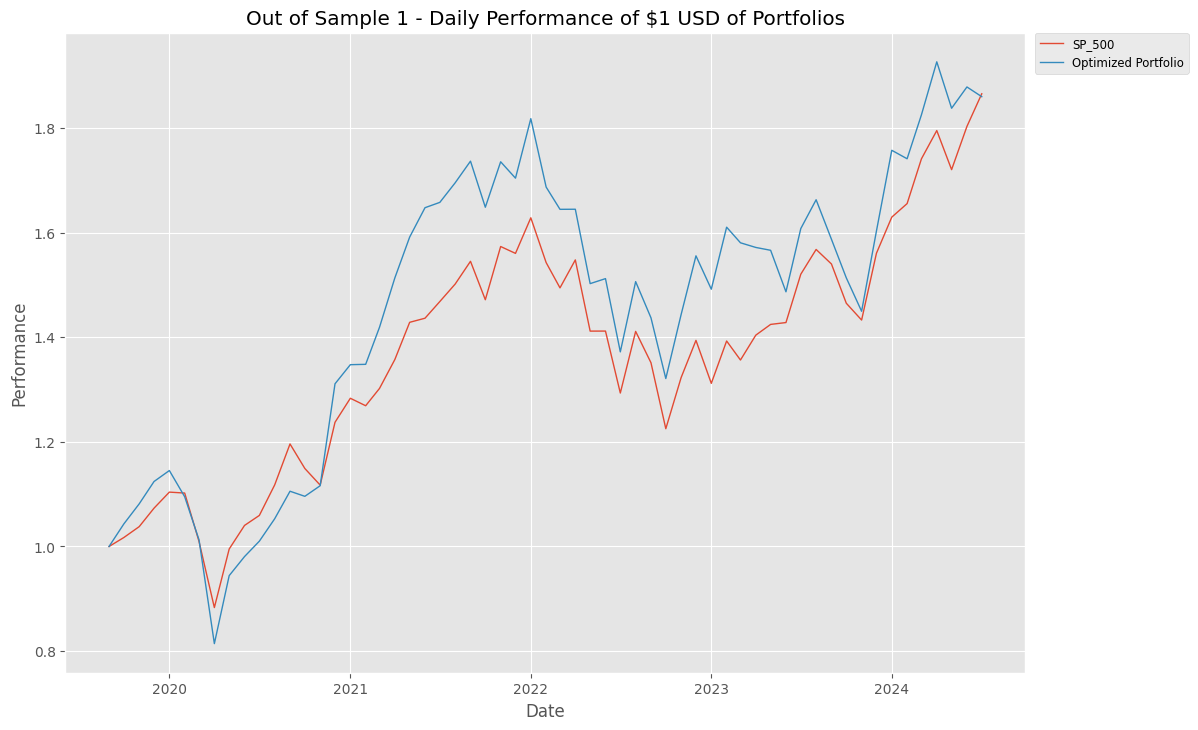

In [413]:
visual()

In [31]:
def random_generate_beta(l,u):
    upper_limit=u
    lower_limit=l
    random_number=round(random.uniform(lower_limit, upper_limit), 2)
    return random_number

In [40]:
testing_beta_mkt=random_generate_beta(1,1.2)
testing_beta_val=random_generate_beta(0,0)
testing_beta_smb=random_generate_beta(0,0)
print(testing_beta_mkt, testing_beta_val,testing_beta_smb)
def run_with_backtestss(nyears):
    
    global n_years
    n_years=nyears
    current_date()
    simulator(testing_beta_mkt,testing_beta_val,testing_beta_smb,n_year_before,n_year_after,1000000,50) 
    out_of_sample()
  
    return oos1_new_performance

run_with_backtestss(3)


1.02 0.0 0.0


[*********************100%%**********************]  501 of 501 completed

6 Failed downloads:
['GEV', 'SOLV', 'SW', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1593576000, endDate = 1688184000")
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2020-07-01 -> 2023-07-01)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  490 of 490 completed


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/645f92fe1ba44eabb5b5b0aad85fc6e5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/645f92fe1ba44eabb5b5b0aad85fc6e5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2529 COLUMNS
At line 44769 RHS
At line 47294 BOUNDS
At line 47785 ENDATA
Problem MODEL has 2524 rows, 2485 columns and 41224 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0004I processed model has 1054 rows, 1505 columns (490 integer (490 of which binary)) and 38284 elements
Cbc0038I Initial state - 36 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 2.17193 ite

[*********************100%%**********************]  36 of 36 completed
[*********************100%%**********************]  1 of 1 completed


Ticker,SP_500,Optimized Portfolio
Date,,
2023-08-01,1.000000,1.000000
2023-09-01,0.982284,0.982084
2023-10-01,0.934427,0.935691
2023-11-01,0.913889,0.906989
2023-12-01,0.995389,0.991257
2024-01-01,1.039414,1.042958
2024-02-01,1.055936,1.045114
2024-03-01,1.110550,1.046608
2024-04-01,1.144998,1.074531


In [109]:
sharess.to_excel('shares2.xlsx')

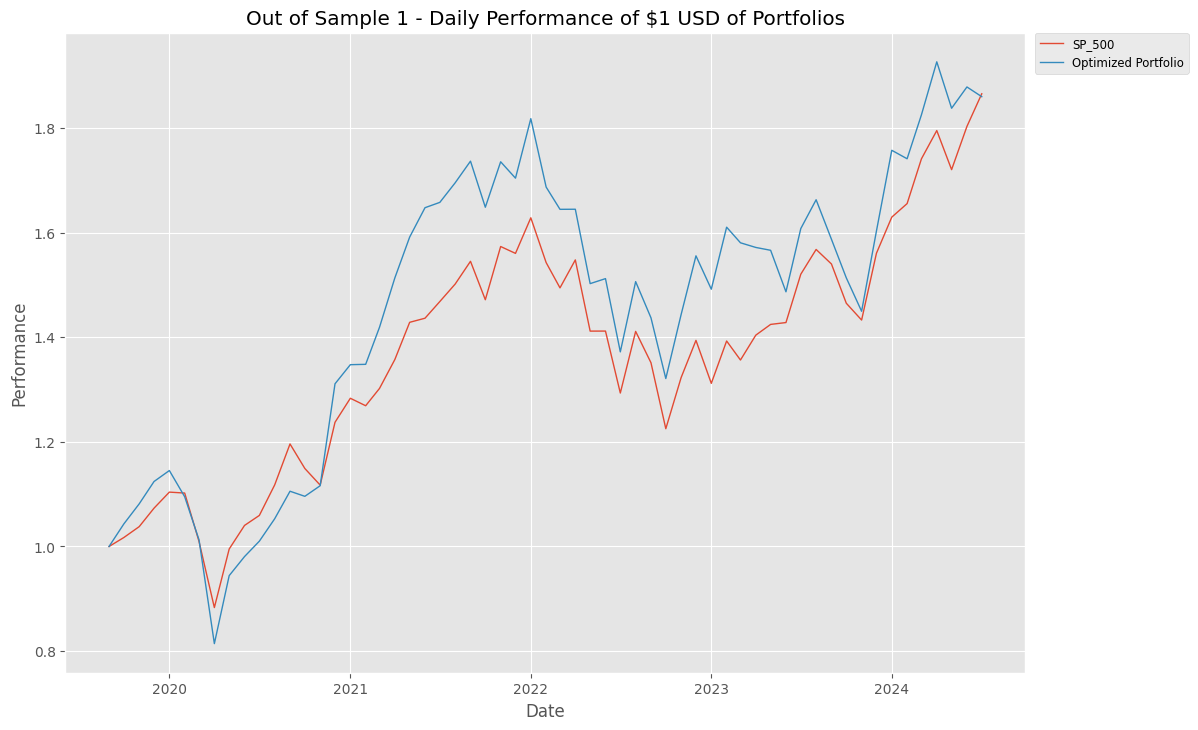

,Mkt-RF,SMB,HML,RF
Mkt-RF,1.000000,0.375112,0.087302,-0.132453
SMB,0.375112,1.000000,0.166171,-0.208541
HML,0.087302,0.166171,1.000000,-0.304060
RF,-0.132453,-0.208541,-0.304060,1.000000


In [414]:
visual()
ff3_monthly.corr()

In [20]:
sharess.to_excel('shares1.xlsx')

In [32]:
#future price function

def get_last_future_price(symbol):
    future = yf.Ticker(symbol)
    data = future.history(period="1d")
    last_price = data['Close'].iloc[-1]
    return last_price


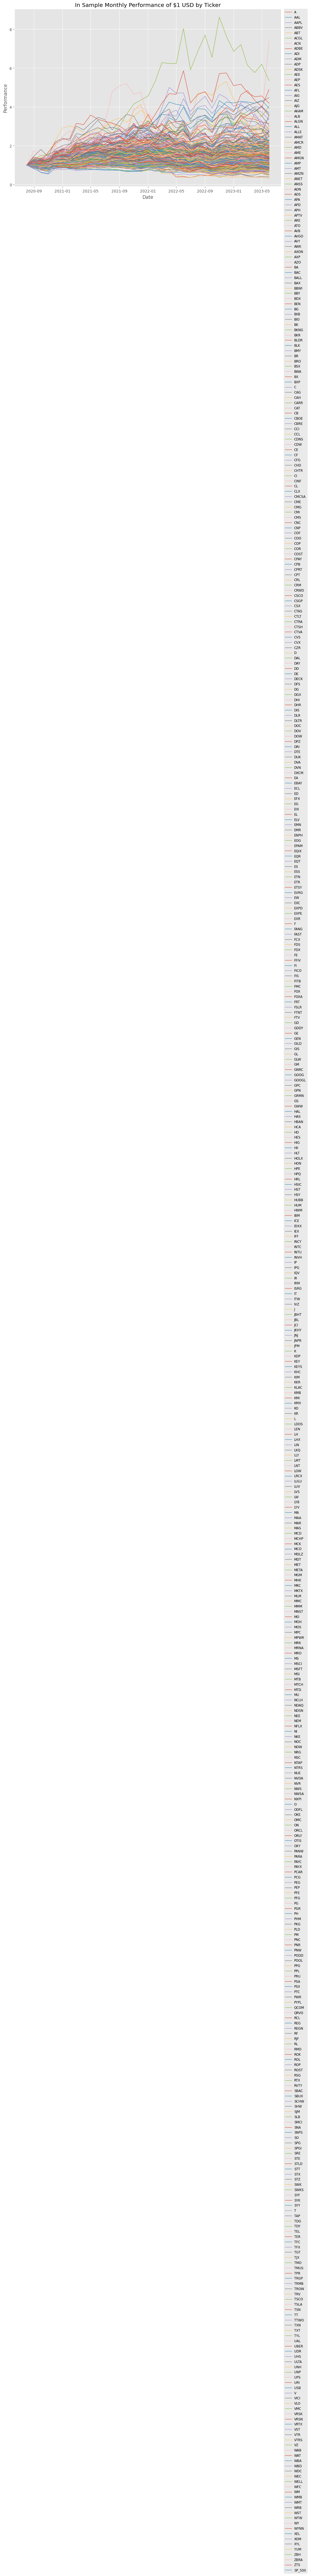

In [82]:
#Adjusting tickers list as some tickers will not be included in the monthly_data if there is no data for test date range
tickers = list(monthly_data.columns[:-1])
tick_index = tickers + ['SP_500']
init = 1        #Initial Common Value (Can be thought of Initial Investment of $1 USD in each stock)
global performance
performance = pd.DataFrame(np.ones((len(monthly_data),len(monthly_data.columns))), index = monthly_data.index, columns = monthly_data.columns)
for j in range(1,len(monthly_data.index)):
    performance.iloc[j] = performance.iloc[j-1]*(monthly_data.iloc[j-1][monthly_data.columns]+init)
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,8), dpi=100)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])   # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
for i in range(0,len(monthly_data.columns)):
        axes.plot(performance.index, performance.iloc[:,i], linewidth=1)

#axes.set_prop_cycle(cycler)
axes.set_xlabel('Date')
axes.set_ylabel('Performance')
axes.set_title('In Sample Monthly Performance of $1 USD by Ticker')
axes.legend(tick_index, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize='small')

plt.show()